In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

In [2]:
API_keys = open('API_KEYS.txt',"r").read().split()

In [3]:
# Runs through stock data and calls strategies and graphs
def algorithims(ticker,cash,show_transactions,show_graphs):
    # Loads in dataframe and renames columns
    API_key = API_keys[random.randint(0,2)]
    time = TimeSeries(key = API_key,output_format='pandas')
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')[0].rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    data = data.sort_index()
    # Splits dataframe into a list of dataframes of each day
    days = [group[1] for group in data.groupby(data.index.dayofyear)]
    num_days = len(days) 
    # Initialize returns for strategies
    strategy1_returns = np.empty(0)
    strategy2_returns = np.empty(0)
    strategy3_returns = np.empty(0)
    strategy4_returns = np.empty(0)
    market_returns = np.empty(0)
    # Loops through dataframes and performs strategies and graphs
    for df in days:
        # Limits data to only during trading hours
        df = df.loc[(df.index >= f'{df.index.date[0]} 9:30:00')]
        df = df.loc[(df.index <= f'{df.index.date[0]} 16:00:00')]   
        # Aggregates one minutes 
        df = df.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})  
        # Add calculated columns for desired indicators 
        df['VWAP'] = (((df['High']+df['Low']+df['Close'])*df['Volume']/3).cumsum())/df['Volume'].cumsum()
        df['percent'] = ((df['Close'])-df['VWAP'])/df['VWAP']
        df['TWAP'] = ((df['Open'] + df['High'] + df['Low'] + df['Close'])/4).expanding().mean()
        df["EMA10"] = df['Close'].ewm(span=10, adjust=False).mean()
        df["EMA20"] = df['Close'].ewm(span=20, adjust=False).mean()
        

        df = df.dropna()
        # Plot indicators and price
        if show_graphs:
            title = f'{ticker}\n{df.index[0].month_name()} {df.index[0].day}, {data.index[0].year}'
            vwap = mpf.make_addplot(df['VWAP'])
            twap = mpf.make_addplot(df['TWAP'])
            ema10 = mpf.make_addplot(df['EMA10'])
            ema20 = mpf.make_addplot(df['EMA20'])
            fig, axes = mpf.plot(df,addplot=[vwap,twap,ema10,ema20],type='candle',style='yahoo',volume=True,title=title,returnfig=True)
            axes[0].legend( ['VWAP','TWAP','EMA10','EMA20'] )
            plt.show()
              
        # Run strategies and add up returns using numpy arrays
        strategy1_returns = np.append(strategy1_returns,strategy1(df,ticker,cash/num_days,show_transactions))
        strategy2_returns = np.append(strategy2_returns,strategy2(df,ticker,cash/num_days,show_transactions))
        strategy3_returns = np.append(strategy3_returns,strategy3(df,ticker,cash/num_days,show_transactions))
        strategy4_returns = np.append(strategy4_returns,strategy4(df,ticker,cash/num_days,show_transactions))
        market_returns = np.append(market_returns,market(df,ticker,cash/num_days))
    # Plots the price of the stock over the period
    if show_graphs:
        title = f'{ticker}\n{data.index[0].month_name()} {data.index[0].day}, {data.index[0].year}-{data.index[-1].month_name()} {data.index[-1].day}, {data.index[-1].year}'
        mpf.plot(data,type='line',style='yahoo',title=title)
    returns = np.array([strategy1_returns,strategy2_returns,strategy3_returns,strategy4_returns,market_returns])
    return returns 

In [4]:
# VWAP Cross:
# Long when price crosses above VWAP and short when VWAP goes below
def strategy1(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash:.2f} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['VWAP'] < row['Open']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['VWAP'] > row['Open']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [5]:
# VWAP Mean Reversion: 
# Long at troughs and short at peaks with assumption that price will return to VWAP
def strategy2(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Mean reversion with ${cash:.2f} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    percent_from_mean = 0.01
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] > row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['percent'] < -(percent_from_mean)) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['percent'] > percent_from_mean) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [6]:
# EMA
# Uses the cross of a fast (10Day) and slow (20Day) moving as a signal to buy or sell
def strategy3(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting EMA Cross strategy with ${cash:.2f} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    transactions = 0
    for index,row in df.iterrows():
        # if (not i): 
            # sets initial position based on inital VWAP and price
            # long = row['VWAP'] < row['Close'] 
            # short = not long
            # transactions += 1
            # i += 1
            # if long:
            #     shares = cash/row['Close']
            #     cash = 0
            #     if show_transactions:
            #         print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            # if short:
            #     shorts = cash/row['Close']
            #     cash = cash0*2
            #     if show_transactions:
            #         print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Buy position 
        if ( ( row['EMA10'] > row['EMA20'] ) and cash ):
            shares = cash/row['Close']
            cash = 0
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 1
        
        # Sell position
        if ( ( row['EMA10'] < row['EMA20'] ) and not cash):
            cash = shares*row['Close']
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share") 
            shares = 0
            transactions += 1
        price = row['Close']
    # Exit position and calculate returns
    if show_transactions:
        print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
    cash += shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [7]:
# TWAP + VWAP strategy
# Long when price is greater than VWAP and TWAP and VWAP > TWAP
# Short when price is less than VWAP and TWAP and VWAP < TWAP
def strategy4(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP + TWAP strategy with ${cash:.2f} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            # go long if price is above VWAP and TWAP and VWAP > TWAP
            long = row['VWAP'] < row['Close']
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
                    
        # Long position 
        if ((row['VWAP'] < row['Open']) and (row['VWAP'] < row['Close']) and short and (row['VWAP'] > row['TWAP'])):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
            
        # Short position
        if ((row['VWAP'] > row['Open']) and (row['VWAP'] > row['Close']) and long and (row['VWAP'] < row['TWAP'])):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
        
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [8]:
# Market Performance:
# Returns if you bought at open and sold at close
def market(df,ticker,cash):
    open_price = df['Open'].loc[f'{df.index.date[0]} 9:30:00']
    shares = cash/open_price
    close_price = df['Close'].loc[f'{df.index.date[0]} 16:00:00']
    return shares*close_price

In [9]:
# Prints returns for each strategy for one stock at a time
def print_stock_returns(ticker,returns,cash_per_stock):
    print(f'{ticker} Returns')
    for i in range(0,returns.shape[0]-1):
        print(f'Strategy {i+1}: {(np.sum(returns[i]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print(f'Market    : {(np.sum(returns[-1]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print('-'*70)

In [10]:
# Prints returns for each strategy overall
def print_summary_returns(all_returns,cash,show_graphs):
    strat1 = []
    strat2 = []
    strat3 = []
    strat4 = []
    market = []
    for i in range(0,all_returns.shape[0]):
        if i % 5 == 0:
            strat1 = strat1 + all_returns[i].tolist()
        if i % 5 == 1:
            strat2 = strat2 + all_returns[i].tolist()
        if i % 5 == 2:
            strat3 = strat3 + all_returns[i].tolist()
        if i % 5 == 3:
            strat4 = strat4 + all_returns[i].tolist()
        if i % 5 == 4:
            market = market + all_returns[i].tolist()
    df_returns = pd.DataFrame()
    df_returns['VWAP Cross']     = strat1
    df_returns['VWAP Reversion'] = strat2
    df_returns['EMA Cross']      = strat3
    df_returns['VWAP-TWAP']      = strat4
    df_returns['Market']         = market
    print('Portfolio Returns')
    print(f"Strategy 1: {(df_returns['VWAP Cross'].sum()-cash)*100/cash:.3f}%")
    print(f"Strategy 2: {(df_returns['VWAP Reversion'].sum()-cash)*100/cash:.3f}%")
    print(f"Strategy 3: {(df_returns['EMA Cross'].sum()-cash)*100/cash:.3f}%")
    print(f"Strategy 4: {(df_returns['VWAP-TWAP'].sum()-cash)*100/cash:.3f}%")
    print(f"Market    : {(df_returns['Market'].sum()-cash)*100/cash:.3f}%")
    print('-'*70)
    if show_graphs:
        sns.heatmap(df_returns.corr(), annot = True)
        plt.title("How Correlated are the Strategies to Eachother?")
        plt.xlabel("Strategies")
        plt.ylabel("Strategies")
        plt.show()
    else:
        print(df_returns.corr())

In [11]:
# Calls algorithims function and prints returns using print functions
def main(stocks,cash,show_transactions=False,show_graphs=False):
    # Initializes numpy arrays for returns
    returns = np.empty((0,0))
    all_returns = np.empty((0,11))
    cash_per_stock = cash/len(stocks)
    for ticker in stocks:
        returns = algorithims(ticker,cash_per_stock,show_transactions,show_graphs)
        all_returns = np.append(all_returns,returns,axis=0)
        print_stock_returns(ticker,returns,cash_per_stock)
    print_summary_returns(all_returns,cash,show_graphs)

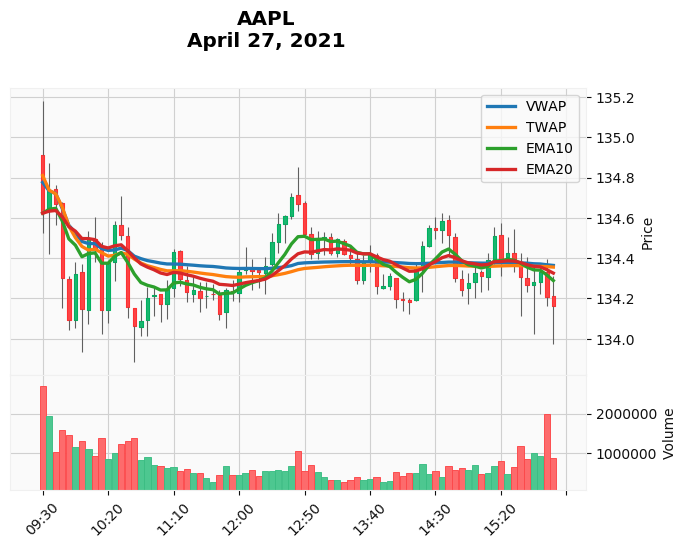

2021-04-27: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 13.506 AAPL short contracts at 134.6225 per contract
10:30:00: Close 13.506 AAPL short contracts at 134.5127 per contract
10:30:00: Buy 13.528 AAPL shares at 134.5127 per share
10:40:00: Sell 13.528 AAPL shares at 134.0635 per share
10:40:00: Open 13.528 AAPL short contracts at 134.0635 per contract
12:25:00: Close 13.528 AAPL short contracts at 134.4811 per contract
12:25:00: Buy 13.444 AAPL shares at 134.4811 per share
13:50:00: Sell 13.444 AAPL shares at 134.2634 per share
13:50:00: Open 13.444 AAPL short contracts at 134.2634 per contract
14:25:00: Close 13.444 AAPL short contracts at 134.5477 per contract
14:25:00: Buy 13.387 AAPL shares at 134.5477 per share
14:50:00: Sell 13.387 AAPL shares at 134.2433 per share
14:50:00: Open 13.387 AAPL short contracts at 134.2433 per contract
15:15:00: Close 13.387 AAPL short contracts at 134.5077 per contract
15:15:00: Buy 13.334 AAPL shares at 134.5077 per share
15:35

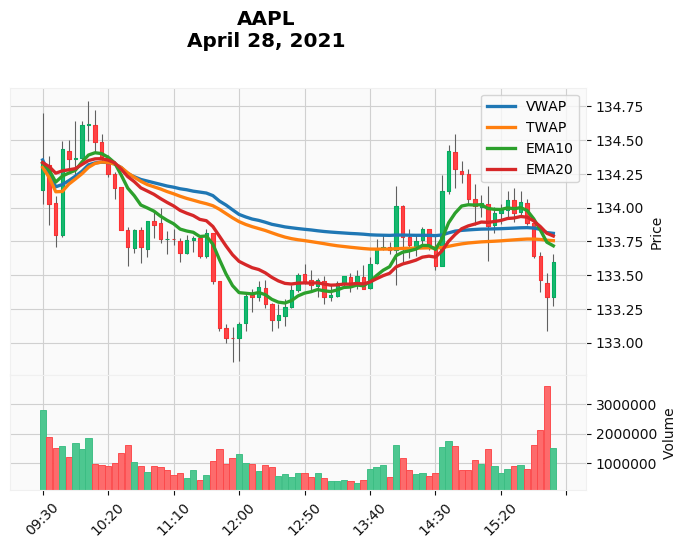

2021-04-28: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 13.535 AAPL short contracts at 134.333 per contract
09:50:00: Close 13.535 AAPL short contracts at 134.358 per contract
09:50:00: Buy 13.530 AAPL shares at 134.358 per share
10:25:00: Sell 13.530 AAPL shares at 134.1434 per share
10:25:00: Open 13.530 AAPL short contracts at 134.1434 per contract
14:40:00: Close 13.530 AAPL short contracts at 134.4179 per contract
14:40:00: Buy 13.475 AAPL shares at 134.4179 per share
15:50:00: Sell 13.475 AAPL shares at 133.4645 per share
15:50:00: Open 13.475 AAPL short contracts at 133.4645 per contract
16:00:00: Close 13.475 AAPL short contracts at 133.5943 per contract
Cash: 1796.6303217831748
Return: -1.19%
Transactions: 10
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 13.535 AAPL shares at 134.333 per share
16:00:00: Sell 13.535 AAPL shares at 133.5943 per share
Cash: 1808.183

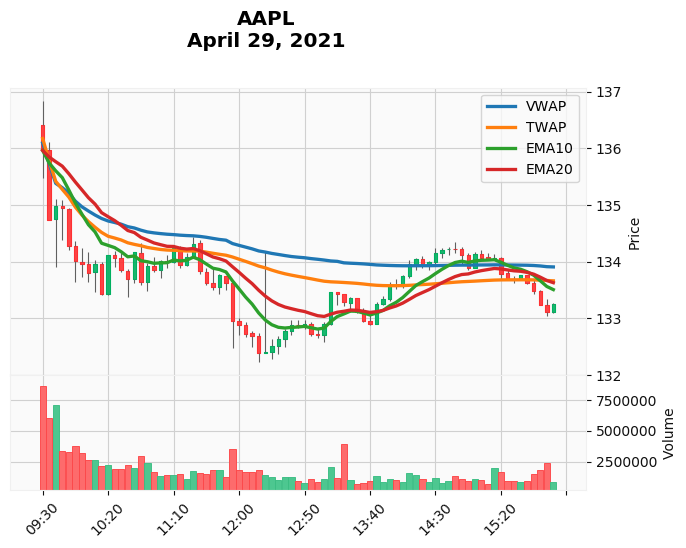

2021-04-29: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 13.373 AAPL short contracts at 135.9603 per contract
14:15:00: Close 13.373 AAPL short contracts at 134.0485 per contract
14:15:00: Buy 13.754 AAPL shares at 134.0485 per share
15:25:00: Sell 13.754 AAPL shares at 133.6941 per share
15:25:00: Open 13.754 AAPL short contracts at 133.6941 per contract
16:00:00: Close 13.754 AAPL short contracts at 133.2549 per contract
Cash: 1844.9144725010399
Return: 1.47%
Transactions: 6
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 13.373 AAPL shares at 135.9603 per share
16:00:00: Sell 13.373 AAPL shares at 133.2549 per share
Cash: 1782.0028079052222
Return: -1.99%
Transactions: 2
----------------------------------------------------------------------
2021-04-29: Starting EMA Cross strategy with $1818.18 USD
13:50:00: Buy 13.635 AAPL shares at 133.3447 per share
15:45:00: Sell 13.63

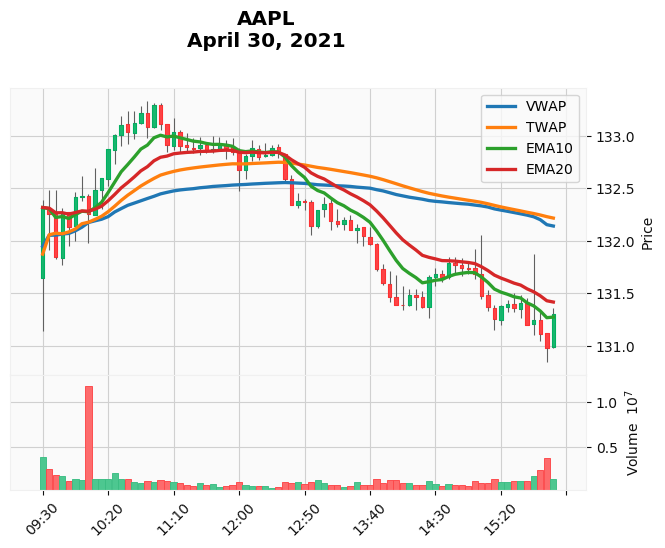

2021-04-30: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 13.741 AAPL shares at 132.3164 per share
12:45:00: Sell 13.741 AAPL shares at 132.3763 per share
12:45:00: Open 13.741 AAPL short contracts at 132.3763 per contract
16:00:00: Close 13.741 AAPL short contracts at 131.2982 per contract
Cash: 1833.8192668207687
Return: 0.86%
Transactions: 4
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 13.741 AAPL short contracts at 132.3164 per contract
16:00:00: Close 13.741 AAPL short contracts at 131.2982 per contract
Cash: 1832.1730749517476
Return: 0.77%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $1818.18 USD
10:10:00: Buy 13.724 AAPL shares at 132.4861 per share
12:35:00: Sell 13.724 AAPL shares at 132.586 per share
16:00:00: Sell 0.000 AAPL shares at 131.2982 per share
Cash: 1819.55280248610

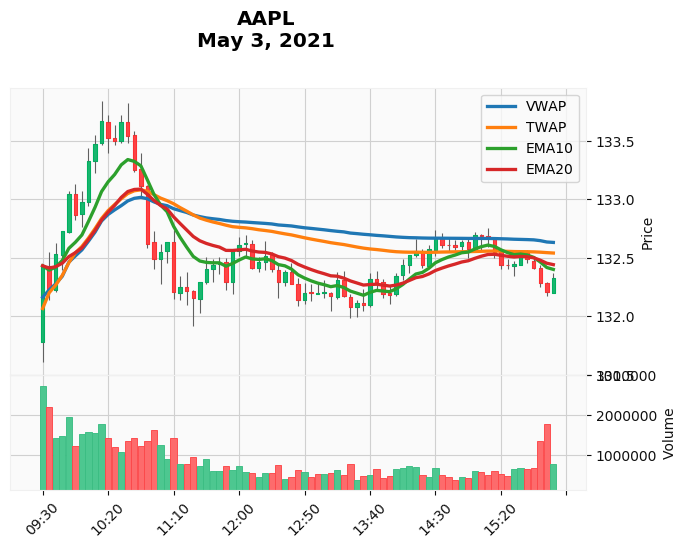

2021-05-03: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 13.729 AAPL shares at 132.4312 per share
10:55:00: Sell 13.729 AAPL shares at 132.4862 per share
10:55:00: Open 13.729 AAPL short contracts at 132.4862 per contract
15:05:00: Close 13.729 AAPL short contracts at 132.6858 per contract
15:05:00: Buy 13.688 AAPL shares at 132.6858 per share
15:20:00: Sell 13.688 AAPL shares at 132.4362 per share
15:20:00: Open 13.688 AAPL short contracts at 132.4362 per contract
16:00:00: Close 13.688 AAPL short contracts at 132.3264 per contract
Cash: 1814.2829924157213
Return: -0.21%
Transactions: 8
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 13.729 AAPL short contracts at 132.4312 per contract
16:00:00: Close 13.729 AAPL short contracts at 132.3264 per contract
Cash: 1819.6206441876645
Return: 0.08%
Transactions: 2
-------------------------------------------------------------------

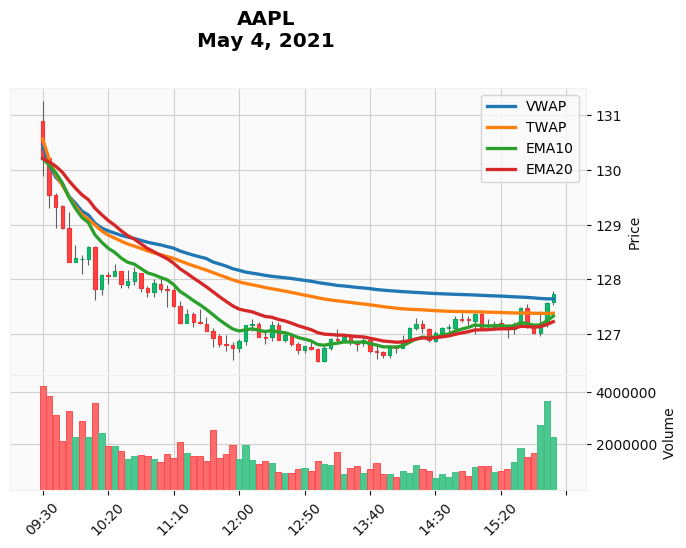

2021-05-04: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 13.963 AAPL short contracts at 130.21 per contract
16:00:00: Close 13.963 AAPL short contracts at 127.7242 per contract
Cash: 1852.8921811618995
Return: 1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 13.963 AAPL shares at 130.21 per share
16:00:00: Sell 13.963 AAPL shares at 127.7242 per share
Cash: 1783.471455201737
Return: -1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting EMA Cross strategy with $1818.18 USD
14:20:00: Buy 14.305 AAPL shares at 127.1052 per share
16:00:00: Sell 14.305 AAPL shares at 127.7242 per share
Cash: 1827.0363303926054
Return: 0.49%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting VWAP + TWAP strategy with $1818.18 USD
09:30:00: Open 13.963 AAPL shor

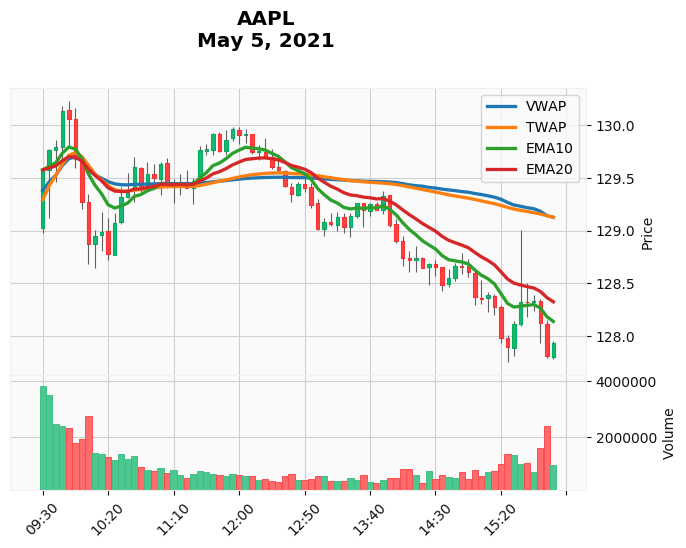

2021-05-05: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 14.032 AAPL shares at 129.5741 per share
10:05:00: Sell 14.032 AAPL shares at 128.8757 per share
10:05:00: Open 14.032 AAPL short contracts at 128.8757 per contract
10:55:00: Close 14.032 AAPL short contracts at 129.4995 per contract
10:55:00: Buy 13.897 AAPL shares at 129.4995 per share
11:10:00: Sell 13.897 AAPL shares at 129.4213 per share
11:10:00: Open 13.897 AAPL short contracts at 129.4213 per contract
11:30:00: Close 13.897 AAPL short contracts at 129.7607 per contract
11:30:00: Buy 13.824 AAPL shares at 129.7607 per share
12:40:00: Sell 13.824 AAPL shares at 129.3415 per share
12:40:00: Open 13.824 AAPL short contracts at 129.3415 per contract
16:00:00: Close 13.824 AAPL short contracts at 127.9338 per contract
Cash: 1807.4905506798127
Return: -0.59%
Transactions: 12
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: 

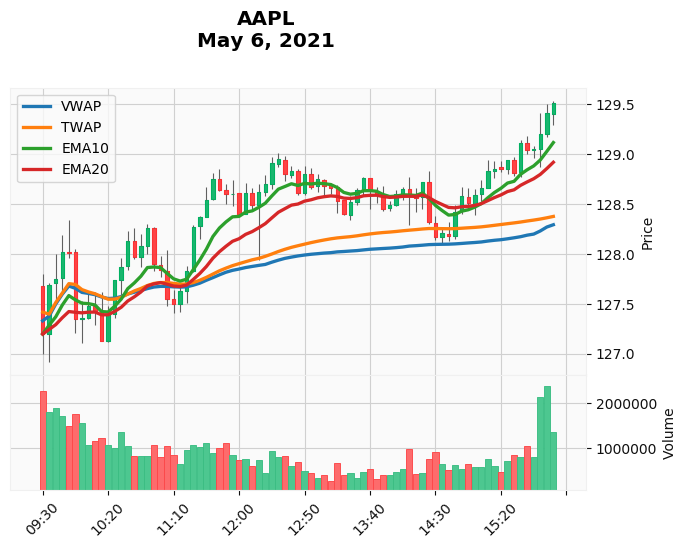

2021-05-06: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 14.294 AAPL short contracts at 127.1951 per contract
09:40:00: Close 14.294 AAPL short contracts at 127.7442 per contract
09:40:00: Buy 14.172 AAPL shares at 127.7442 per share
10:00:00: Sell 14.172 AAPL shares at 127.3548 per share
10:00:00: Open 14.172 AAPL short contracts at 127.3548 per contract
10:30:00: Close 14.172 AAPL short contracts at 127.864 per contract
10:30:00: Buy 14.059 AAPL shares at 127.864 per share
11:10:00: Sell 14.059 AAPL shares at 127.4996 per share
11:10:00: Open 14.059 AAPL short contracts at 127.4996 per contract
11:25:00: Close 14.059 AAPL short contracts at 128.2683 per contract
11:25:00: Buy 13.890 AAPL shares at 128.2683 per share
16:00:00: Sell 13.890 AAPL shares at 129.5112 per share
Cash: 1798.9324021891557
Return: -1.06%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Bu

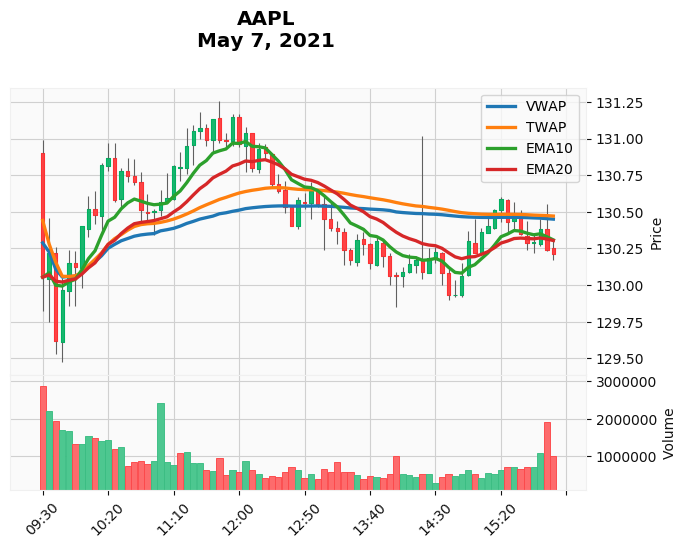

2021-05-07: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 13.980 AAPL short contracts at 130.0535 per contract
09:55:00: Close 13.980 AAPL short contracts at 130.12 per contract
09:55:00: Buy 13.966 AAPL shares at 130.12 per share
12:40:00: Sell 13.966 AAPL shares at 130.4 per share
12:40:00: Open 13.966 AAPL short contracts at 130.4 per contract
12:50:00: Close 13.966 AAPL short contracts at 130.56 per contract
12:50:00: Buy 13.932 AAPL shares at 130.56 per share
13:10:00: Sell 13.932 AAPL shares at 130.39 per share
13:10:00: Open 13.932 AAPL short contracts at 130.39 per contract
15:20:00: Close 13.932 AAPL short contracts at 130.59 per contract
15:20:00: Buy 13.889 AAPL shares at 130.59 per share
15:40:00: Sell 13.889 AAPL shares at 130.29 per share
15:40:00: Open 13.889 AAPL short contracts at 130.29 per contract
16:00:00: Close 13.889 AAPL short contracts at 130.21 per contract
Cash: 1810.7177085388034
Return: -0.41%
Transactions: 14
-------------------------------

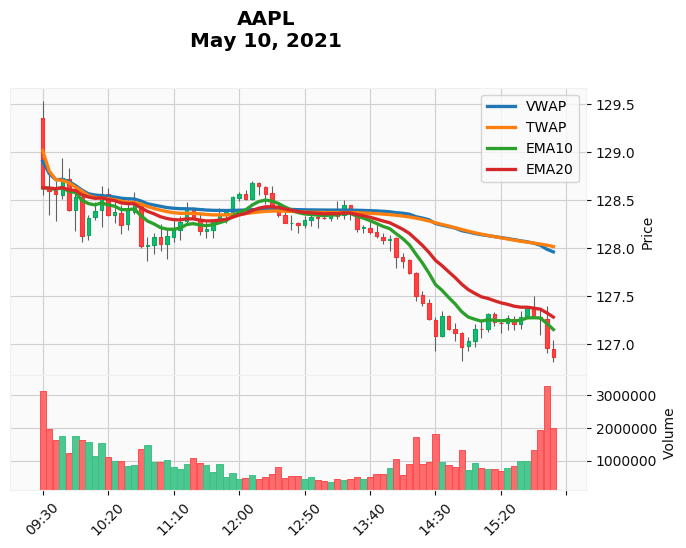

2021-05-10: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 14.135 AAPL short contracts at 128.63 per contract
12:00:00: Close 14.135 AAPL short contracts at 128.57 per contract
12:00:00: Buy 14.148 AAPL shares at 128.57 per share
12:35:00: Sell 14.148 AAPL shares at 128.265 per share
12:35:00: Open 14.148 AAPL short contracts at 128.265 per contract
16:00:00: Close 14.148 AAPL short contracts at 126.86 per contract
Cash: 1834.592901105697
Return: 0.90%
Transactions: 6
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 14.135 AAPL shares at 128.63 per share
16:00:00: Sell 14.135 AAPL shares at 126.86 per share
Cash: 1793.1629126529228
Return: -1.38%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $1818.18 USD
09:45:00: Buy 14.124 AAPL shares at 128.7297 per share
09:50:00: Sell 14.124 AAPL shares a

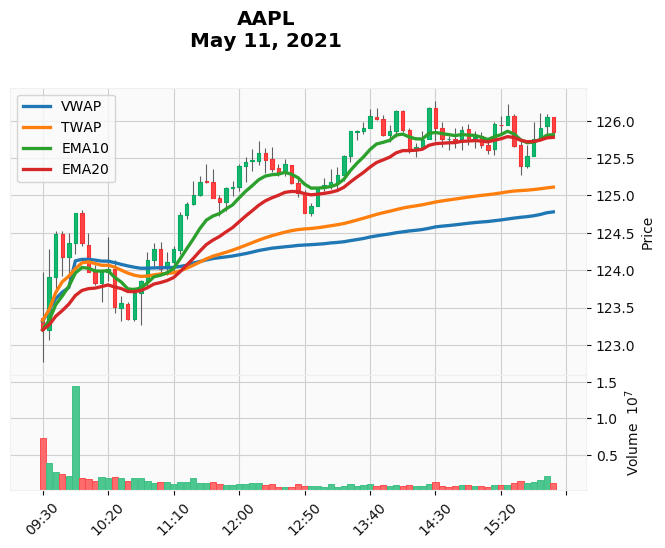

2021-05-11: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 14.758 AAPL short contracts at 123.2 per contract
09:40:00: Close 14.758 AAPL short contracts at 124.48 per contract
09:40:00: Buy 14.454 AAPL shares at 124.48 per share
10:10:00: Sell 14.454 AAPL shares at 123.83 per share
10:10:00: Open 14.454 AAPL short contracts at 123.83 per contract
10:55:00: Close 14.454 AAPL short contracts at 124.285 per contract
10:55:00: Buy 14.349 AAPL shares at 124.285 per share
16:00:00: Sell 14.349 AAPL shares at 125.85 per share
Cash: 1805.7750406898833
Return: -0.68%
Transactions: 8
----------------------------------------------------------------------
2021-05-11: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 14.758 AAPL shares at 123.2 per share
12:15:00: Sell 14.758 AAPL shares at 125.57 per share
12:15:00: Open 14.758 AAPL short contracts at 125.57 per contract
16:00:00: Close 14.758 AAPL short contracts at 125.85 per contract
Cash: 1849.025974025974
Return: 1.7

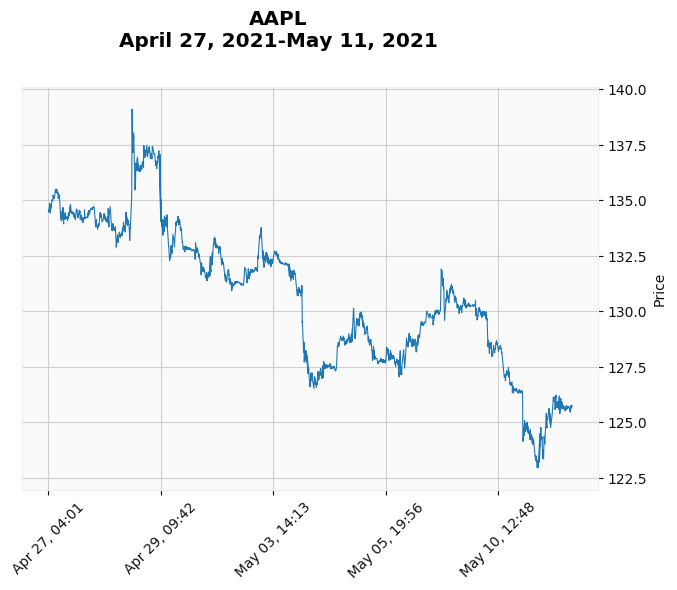

AAPL Returns
Strategy 1: -0.036%
Strategy 2: -0.045%
Strategy 3: -0.028%
Strategy 4: -0.213%
Market    : -0.490%
----------------------------------------------------------------------


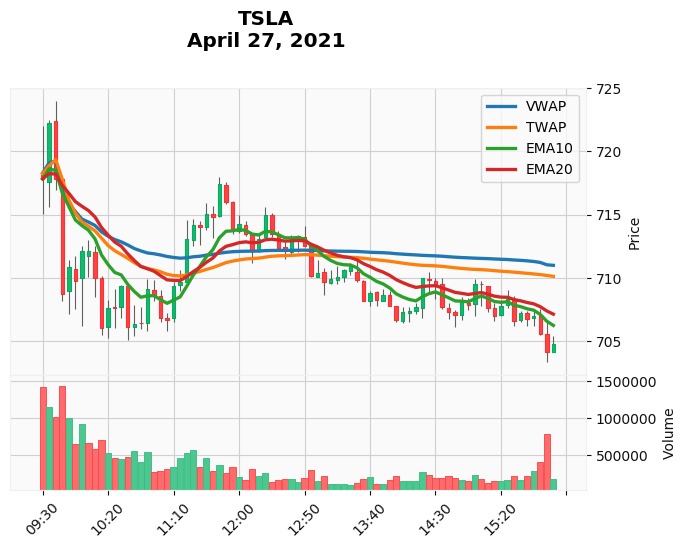

2021-04-27: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.533 TSLA short contracts at 717.82 per contract
11:25:00: Close 2.533 TSLA short contracts at 714.2101 per contract
11:25:00: Buy 2.559 TSLA shares at 714.2101 per share
13:00:00: Sell 2.559 TSLA shares at 710.4061 per share
13:00:00: Open 2.559 TSLA short contracts at 710.4061 per contract
16:00:00: Close 2.559 TSLA short contracts at 704.74 per contract
Cash: 1832.0896440943059
Return: 0.76%
Transactions: 6
----------------------------------------------------------------------
2021-04-27: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.533 TSLA shares at 717.82 per share
16:00:00: Sell 2.533 TSLA shares at 704.74 per share
Cash: 1785.0512030111372
Return: -1.82%
Transactions: 2
----------------------------------------------------------------------
2021-04-27: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 2.518 TSLA shares at 722.21 per share
09:45:00: Sell 2.518 TSLA shares at 708

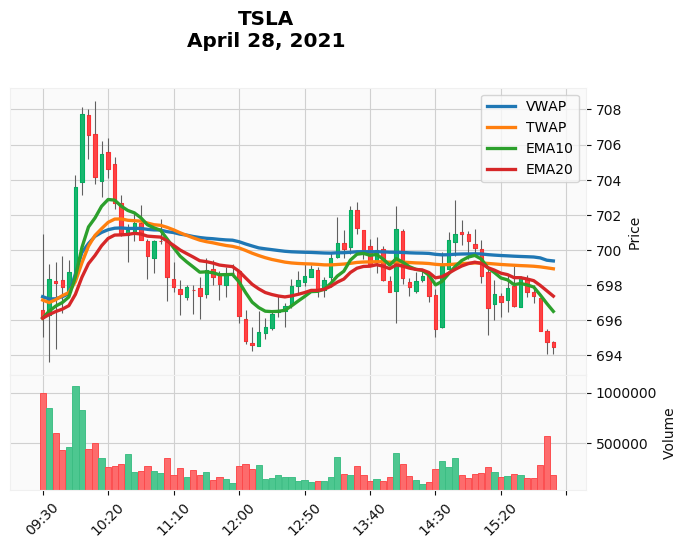

2021-04-28: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.612 TSLA short contracts at 696.0974 per contract
09:40:00: Close 2.612 TSLA short contracts at 698.1001 per contract
09:40:00: Buy 2.597 TSLA shares at 698.1001 per share
10:35:00: Sell 2.597 TSLA shares at 701.14 per share
10:35:00: Open 2.597 TSLA short contracts at 701.14 per contract
13:20:00: Close 2.597 TSLA short contracts at 700.034 per contract
13:20:00: Buy 2.605 TSLA shares at 700.034 per share
13:55:00: Sell 2.605 TSLA shares at 697.58 per share
13:55:00: Open 2.605 TSLA short contracts at 697.58 per contract
14:45:00: Close 2.605 TSLA short contracts at 700.9164 per contract
14:45:00: Buy 2.580 TSLA shares at 700.9164 per share
15:10:00: Sell 2.580 TSLA shares at 696.695 per share
15:10:00: Open 2.580 TSLA short contracts at 696.695 per contract
16:00:00: Close 2.580 TSLA short contracts at 694.46 per contract
Cash: 1803.5069170272027
Return: -0.81%
Transactions: 14
-------------------------------

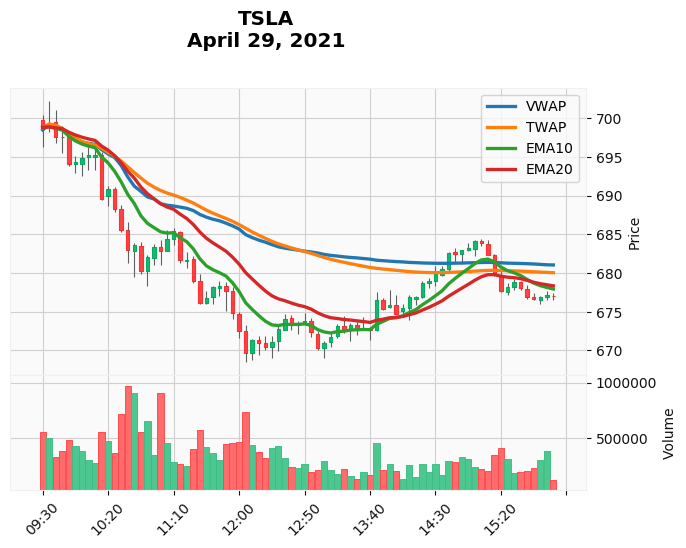

2021-04-29: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 2.602 TSLA shares at 698.8046 per share
09:45:00: Sell 2.602 TSLA shares at 697.53 per share
09:45:00: Open 2.602 TSLA short contracts at 697.53 per contract
14:45:00: Close 2.602 TSLA short contracts at 682.4401 per contract
14:45:00: Buy 2.717 TSLA shares at 682.4401 per share
15:20:00: Sell 2.717 TSLA shares at 677.6895 per share
15:20:00: Open 2.717 TSLA short contracts at 677.6895 per contract
16:00:00: Close 2.717 TSLA short contracts at 677.0 per contract
Cash: 1843.093462694103
Return: 1.37%
Transactions: 8
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 2.602 TSLA short contracts at 698.8046 per contract
10:30:00: Close 2.602 TSLA short contracts at 685.5576 per contract
10:30:00: Buy 2.702 TSLA shares at 685.5576 per share
16:00:00: Sell 2.702 TSLA shares at 677.0 per share
Cash: 1829.5224411594481
Return: 0.

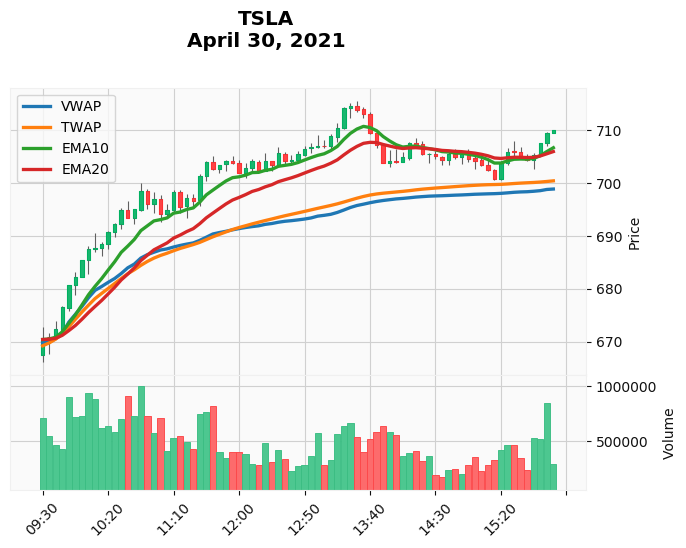

2021-04-30: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 2.712 TSLA shares at 670.39 per share
16:00:00: Sell 2.712 TSLA shares at 709.84 per share
Cash: 1925.1751694061397
Return: 5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 2.712 TSLA short contracts at 670.39 per contract
16:00:00: Close 2.712 TSLA short contracts at 709.84 per contract
Cash: 1711.1884669574968
Return: -5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 2.710 TSLA shares at 670.9178 per share
14:30:00: Sell 2.710 TSLA shares at 705.09 per share
15:50:00: Buy 2.701 TSLA shares at 707.43 per share
16:00:00: Sell 2.701 TSLA shares at 709.84 per share
Cash: 1917.2976814959263
Return: 5.45%
Transactions: 4
--------------------------------------------------------------------

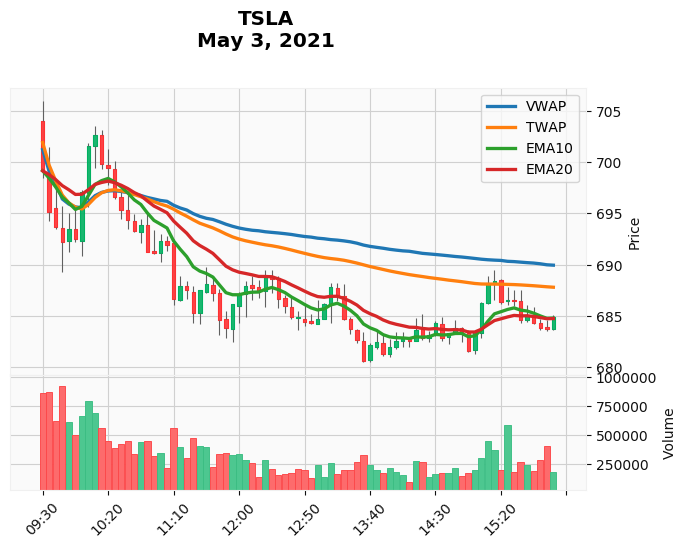

2021-05-03: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.601 TSLA short contracts at 699.16 per contract
10:05:00: Close 2.601 TSLA short contracts at 701.5678 per contract
10:05:00: Buy 2.583 TSLA shares at 701.5678 per share
10:30:00: Sell 2.583 TSLA shares at 695.3616 per share
10:30:00: Open 2.583 TSLA short contracts at 695.3616 per contract
16:00:00: Close 2.583 TSLA short contracts at 684.8748 per contract
Cash: 1822.9756687920465
Return: 0.26%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.601 TSLA shares at 699.16 per share
16:00:00: Sell 2.601 TSLA shares at 684.8748 per share
Cash: 1781.0328238041498
Return: -2.04%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $1818.18 USD
10:10:00: Buy 2.588 TSLA shares at 702.64 per share
10:30:00: Sell 2.588 TSLA shares at

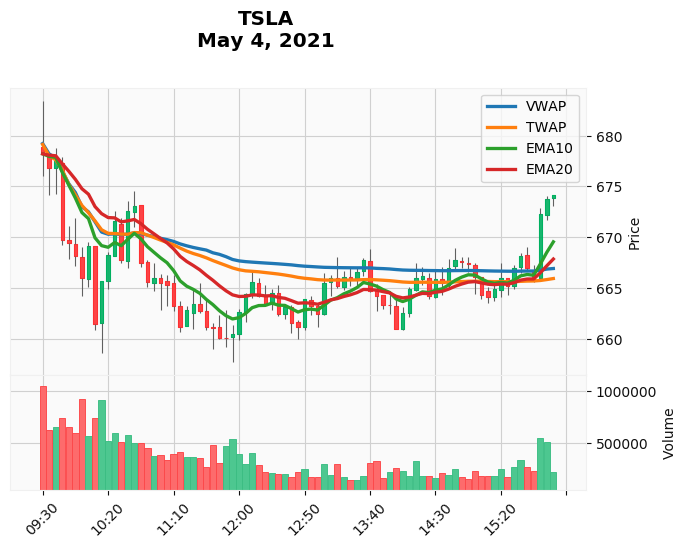

2021-05-04: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.681 TSLA short contracts at 678.21 per contract
10:40:00: Close 2.681 TSLA short contracts at 673.03 per contract
10:40:00: Buy 2.722 TSLA shares at 673.03 per share
10:50:00: Sell 2.722 TSLA shares at 665.58 per share
10:50:00: Open 2.722 TSLA short contracts at 665.58 per contract
14:45:00: Close 2.722 TSLA short contracts at 667.78 per contract
14:45:00: Buy 2.704 TSLA shares at 667.78 per share
15:05:00: Sell 2.704 TSLA shares at 664.31 per share
15:05:00: Open 2.704 TSLA short contracts at 664.31 per contract
15:35:00: Close 2.704 TSLA short contracts at 668.1339 per contract
15:35:00: Buy 2.673 TSLA shares at 668.1339 per share
16:00:00: Sell 2.673 TSLA shares at 674.18 per share
Cash: 1802.238750565676
Return: -0.88%
Transactions: 12
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.681 TSLA shares at 678.21 p

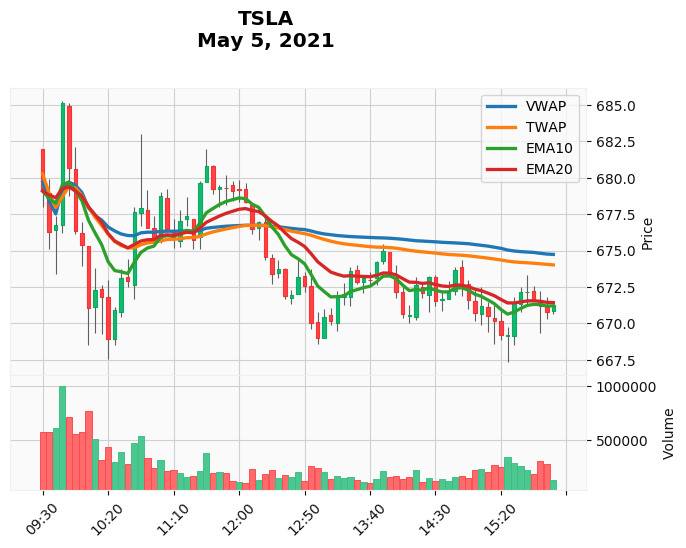

2021-05-05: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.677 TSLA short contracts at 679.0862 per contract
09:50:00: Close 2.677 TSLA short contracts at 680.67 per contract
09:50:00: Buy 2.665 TSLA shares at 680.67 per share
10:00:00: Sell 2.665 TSLA shares at 675.3799 per share
10:00:00: Open 2.665 TSLA short contracts at 675.3799 per contract
10:45:00: Close 2.665 TSLA short contracts at 677.9 per contract
10:45:00: Buy 2.645 TSLA shares at 677.9 per share
12:25:00: Sell 2.645 TSLA shares at 673.4019 per share
12:25:00: Open 2.645 TSLA short contracts at 673.4019 per contract
16:00:00: Close 2.645 TSLA short contracts at 671.28 per contract
Cash: 1786.8423473646617
Return: -1.72%
Transactions: 10
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.677 TSLA shares at 679.0862 per share
16:00:00: Sell 2.677 TSLA shares at 671.28 per share
Cash: 1797.2815393820267
Return: -1.

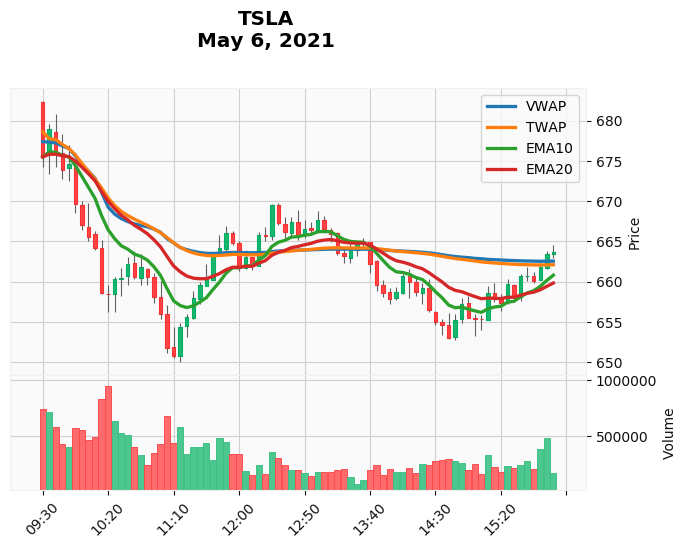

2021-05-06: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.692 TSLA short contracts at 675.48 per contract
11:45:00: Close 2.692 TSLA short contracts at 664.1301 per contract
11:45:00: Buy 2.784 TSLA shares at 664.1301 per share
12:05:00: Sell 2.784 TSLA shares at 663.0844 per share
12:05:00: Open 2.784 TSLA short contracts at 663.0844 per contract
12:20:00: Close 2.784 TSLA short contracts at 665.64 per contract
12:20:00: Buy 2.762 TSLA shares at 665.64 per share
13:20:00: Sell 2.762 TSLA shares at 663.1229 per share
13:20:00: Open 2.762 TSLA short contracts at 663.1229 per contract
13:35:00: Close 2.762 TSLA short contracts at 664.7742 per contract
13:35:00: Buy 2.749 TSLA shares at 664.7742 per share
13:45:00: Sell 2.749 TSLA shares at 659.55 per share
13:45:00: Open 2.749 TSLA short contracts at 659.55 per contract
16:00:00: Close 2.749 TSLA short contracts at 663.7 per contract
16:00:00: Buy 2.714 TSLA shares at 663.7 per share
16:00:00: Sell 2.714 TSLA shares at 

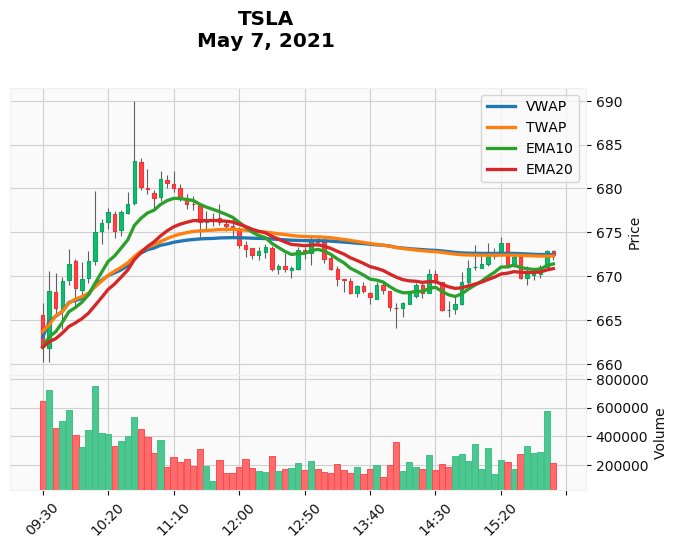

2021-05-07: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.747 TSLA short contracts at 661.9052 per contract
09:40:00: Close 2.747 TSLA short contracts at 666.3934 per contract
09:40:00: Buy 2.710 TSLA shares at 666.3934 per share
12:05:00: Sell 2.710 TSLA shares at 673.1462 per share
12:05:00: Open 2.710 TSLA short contracts at 673.1462 per contract
16:00:00: Close 2.710 TSLA short contracts at 672.36 per contract
Cash: 1826.2830847426064
Return: 0.45%
Transactions: 6
----------------------------------------------------------------------
2021-05-07: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.747 TSLA shares at 661.9052 per share
10:20:00: Sell 2.747 TSLA shares at 677.27 per share
10:20:00: Open 2.747 TSLA short contracts at 677.27 per contract
13:55:00: Close 2.747 TSLA short contracts at 666.47 per contract
13:55:00: Buy 2.836 TSLA shares at 666.47 per share
16:00:00: Sell 2.836 TSLA shares at 672.36 per share
Cash: 1906.7572387686394
Return: 4.8

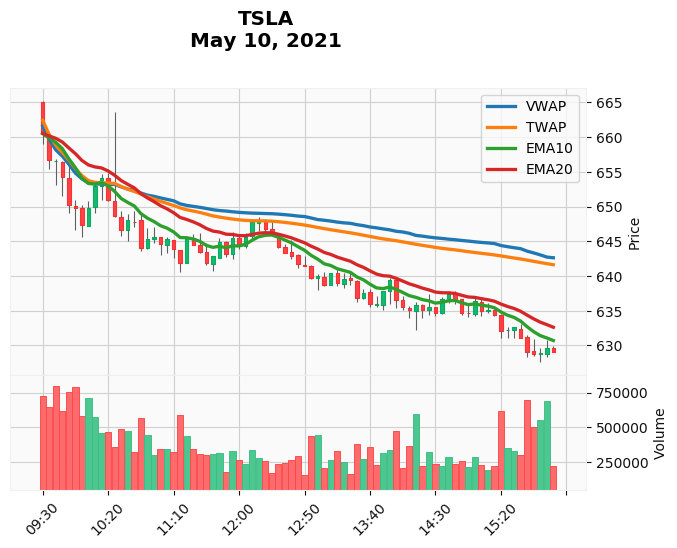

2021-05-10: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 2.753 TSLA short contracts at 660.53 per contract
16:00:00: Close 2.753 TSLA short contracts at 629.04 per contract
Cash: 1904.8615230469197
Return: 4.77%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 2.753 TSLA shares at 660.53 per share
16:00:00: Sell 2.753 TSLA shares at 629.04 per share
Cash: 1731.5021133167168
Return: -4.77%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $1818.18 USD
16:00:00: Sell 0.000 TSLA shares at 629.04 per share
Cash: 1818.1818181818182
Return: 0.00%
Transactions: 1
----------------------------------------------------------------------
2021-05-10: Starting VWAP + TWAP strategy with $1818.18 USD
09:30:00: Open 2.753 TSLA short contracts at 660.53 per contract
16:00:00: Close 2.753 TSLA shor

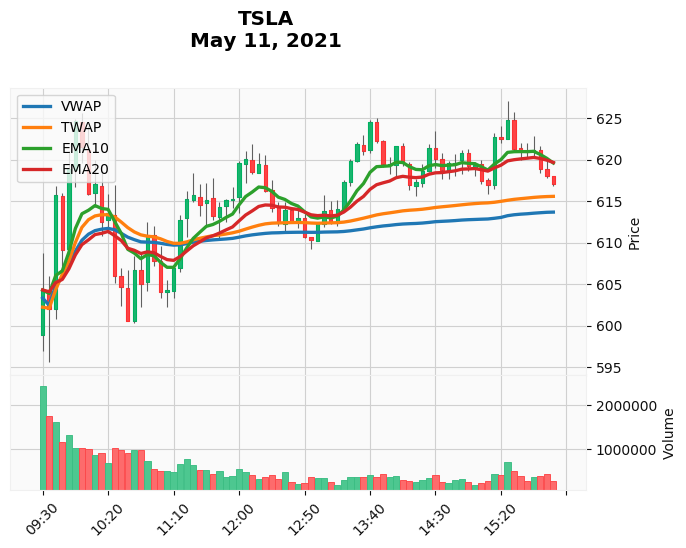

2021-05-11: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 3.009 TSLA shares at 604.2847 per share
10:30:00: Sell 3.009 TSLA shares at 604.6842 per share
10:30:00: Open 3.009 TSLA short contracts at 604.6842 per contract
11:20:00: Close 3.009 TSLA short contracts at 615.225 per contract
11:20:00: Buy 2.906 TSLA shares at 615.225 per share
12:55:00: Sell 2.906 TSLA shares at 610.25 per share
12:55:00: Open 2.906 TSLA short contracts at 610.25 per contract
13:05:00: Close 2.906 TSLA short contracts at 613.849 per contract
13:05:00: Buy 2.872 TSLA shares at 613.849 per share
16:00:00: Sell 2.872 TSLA shares at 617.04 per share
Cash: 1771.9183177217321
Return: -2.54%
Transactions: 10
----------------------------------------------------------------------
2021-05-11: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 3.009 TSLA short contracts at 604.2847 per contract
10:30:00: Close 3.009 TSLA short contracts at 604.6842 per contract
10:30:00: Buy 3.005 TSLA shares 

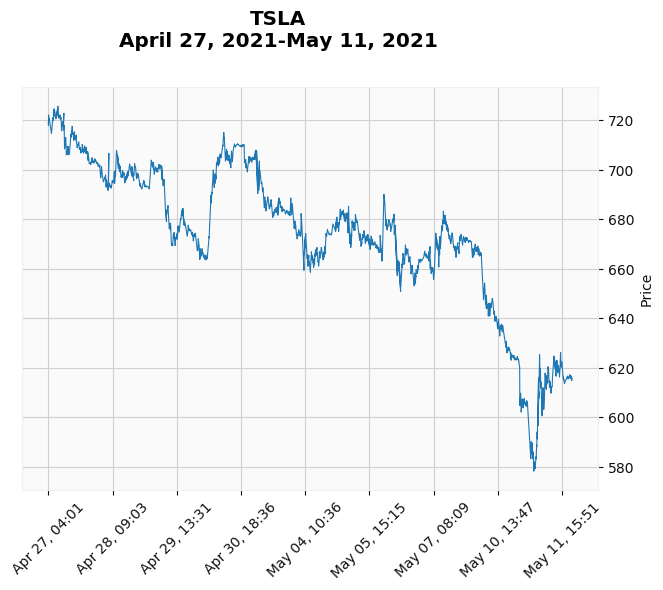

TSLA Returns
Strategy 1: 0.602%
Strategy 2: -0.568%
Strategy 3: -0.288%
Strategy 4: 0.733%
Market    : -0.741%
----------------------------------------------------------------------


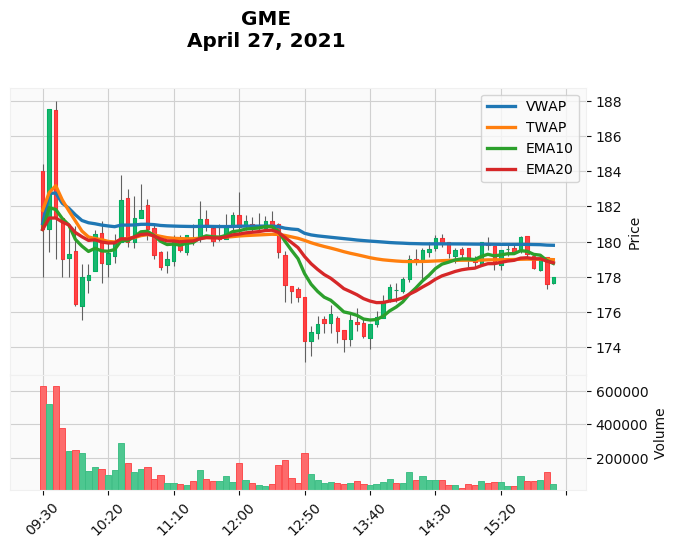

2021-04-27: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 10.062 GME short contracts at 180.6898 per contract
10:45:00: Close 10.062 GME short contracts at 181.79 per contract
10:45:00: Buy 9.941 GME shares at 181.79 per share
10:55:00: Sell 9.941 GME shares at 179.27 per share
10:55:00: Open 9.941 GME short contracts at 179.27 per contract
11:35:00: Close 9.941 GME short contracts at 180.93 per contract
11:35:00: Buy 9.758 GME shares at 180.93 per share
11:40:00: Sell 9.758 GME shares at 180.0211 per share
11:40:00: Open 9.758 GME short contracts at 180.0211 per contract
11:55:00: Close 9.758 GME short contracts at 181.503 per contract
11:55:00: Buy 9.599 GME shares at 181.503 per share
12:35:00: Sell 9.599 GME shares at 177.52 per share
12:35:00: Open 9.599 GME short contracts at 177.52 per contract
16:00:00: Close 9.599 GME short contracts at 178.0 per contract
Cash: 1699.389284748593
Return: -6.53%
Transactions: 14
---------------------------------------------------

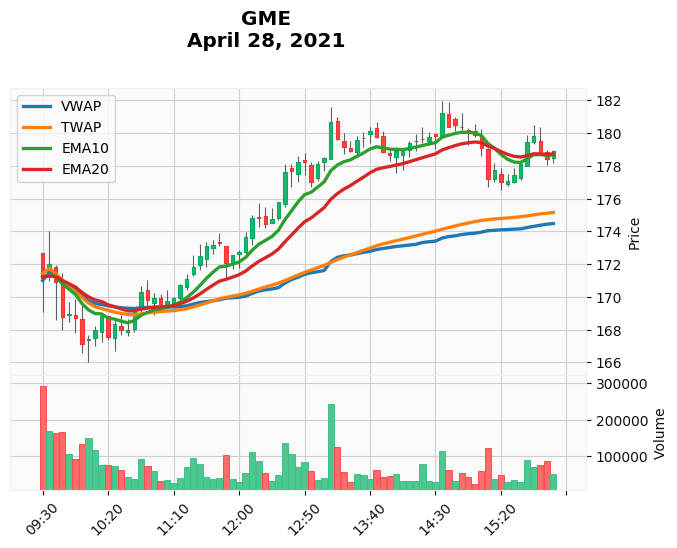

2021-04-28: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 10.620 GME shares at 171.2 per share
09:45:00: Sell 10.620 GME shares at 168.8 per share
09:45:00: Open 10.620 GME short contracts at 168.8 per contract
10:50:00: Close 10.620 GME short contracts at 169.84 per contract
10:50:00: Buy 10.490 GME shares at 169.84 per share
16:00:00: Sell 10.490 GME shares at 178.91 per share
Cash: 1876.7939819215128
Return: 3.22%
Transactions: 6
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 10.620 GME short contracts at 171.2 per contract
09:45:00: Close 10.620 GME short contracts at 168.8 per contract
09:45:00: Buy 10.922 GME shares at 168.8 per share
11:25:00: Sell 10.922 GME shares at 171.81 per share
11:25:00: Open 10.922 GME short contracts at 171.81 per contract
16:00:00: Close 10.922 GME short contracts at 178.91 per contract
Cash: 1798.9984779361132
Return: -1.06%
Transactions: 

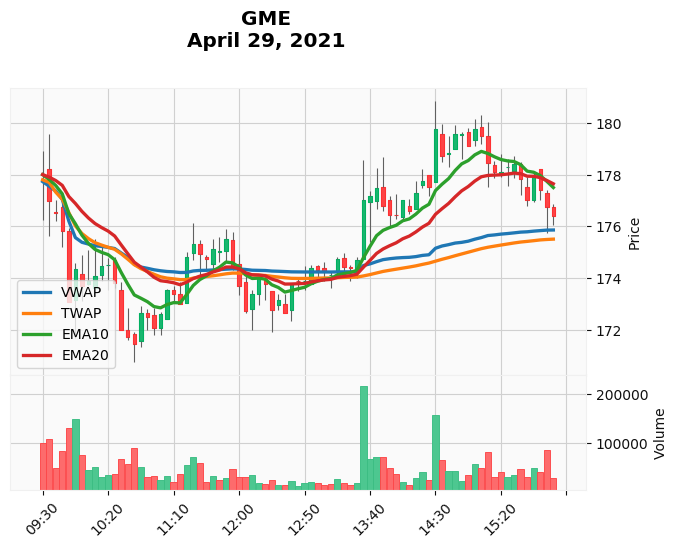

2021-04-29: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 10.215 GME shares at 178.0 per share
09:40:00: Sell 10.215 GME shares at 176.52 per share
09:40:00: Open 10.215 GME short contracts at 176.52 per contract
11:25:00: Close 10.215 GME short contracts at 175.3 per contract
11:25:00: Buy 10.357 GME shares at 175.3 per share
12:05:00: Sell 10.357 GME shares at 172.74 per share
12:05:00: Open 10.357 GME short contracts at 172.74 per contract
13:00:00: Close 10.357 GME short contracts at 174.315 per contract
13:00:00: Buy 10.170 GME shares at 174.315 per share
13:10:00: Sell 10.170 GME shares at 174.133 per share
13:10:00: Open 10.170 GME short contracts at 174.133 per contract
13:20:00: Close 10.170 GME short contracts at 174.41 per contract
13:20:00: Buy 10.137 GME shares at 174.41 per share
16:00:00: Sell 10.137 GME shares at 176.41 per share
Cash: 1788.3078104950587
Return: -1.64%
Transactions: 14
----------------------------------------------------------------------

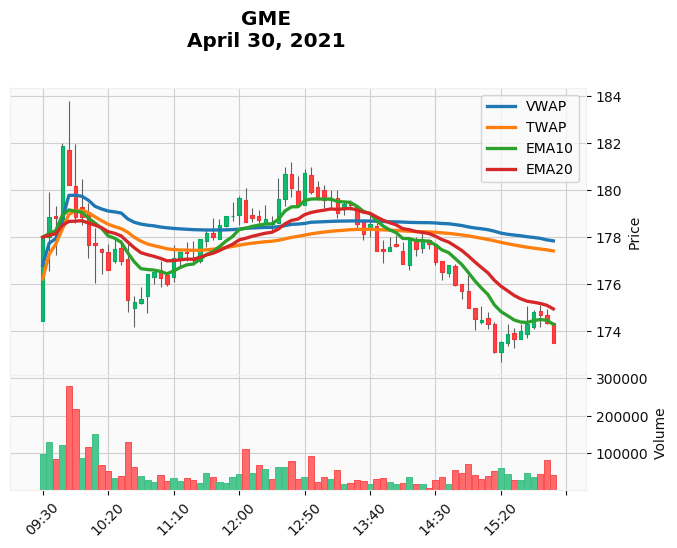

2021-04-30: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 10.215 GME shares at 178.0 per share
10:00:00: Sell 10.215 GME shares at 178.8696 per share
10:00:00: Open 10.215 GME short contracts at 178.8696 per contract
11:50:00: Close 10.215 GME short contracts at 178.8875 per contract
11:50:00: Buy 10.212 GME shares at 178.8875 per share
13:40:00: Sell 10.212 GME shares at 178.57 per share
13:40:00: Open 10.212 GME short contracts at 178.57 per contract
16:00:00: Close 10.212 GME short contracts at 173.51 per contract
Cash: 1875.3141052451565
Return: 3.14%
Transactions: 8
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 10.215 GME short contracts at 178.0 per contract
10:05:00: Close 10.215 GME short contracts at 177.6655 per contract
10:05:00: Buy 10.253 GME shares at 177.6655 per share
12:35:00: Sell 10.253 GME shares at 180.6999 per share
12:35:00: Open 10.253 GME short cont

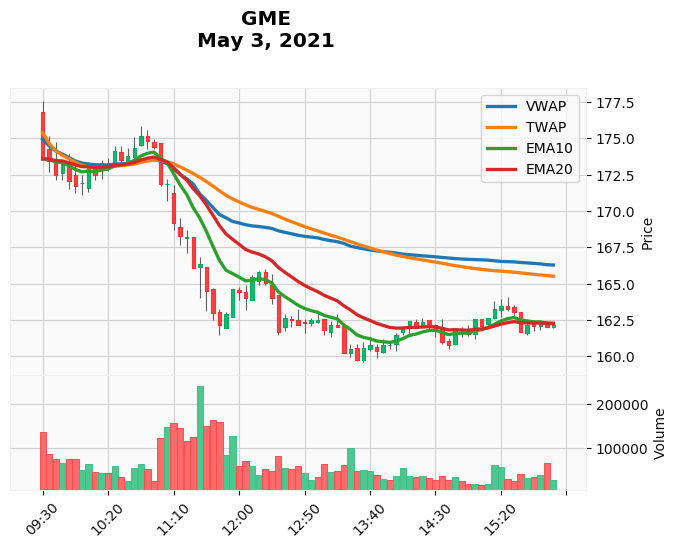

2021-05-03: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 10.474 GME short contracts at 173.59 per contract
10:30:00: Close 10.474 GME short contracts at 173.4999 per contract
10:30:00: Buy 10.485 GME shares at 173.4999 per share
11:05:00: Sell 10.485 GME shares at 171.892 per share
11:05:00: Open 10.485 GME short contracts at 171.892 per contract
16:00:00: Close 10.485 GME short contracts at 162.19 per contract
Cash: 1903.9911879339068
Return: 4.72%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 10.474 GME shares at 173.59 per share
16:00:00: Sell 10.474 GME shares at 162.19 per share
Cash: 1698.778207793704
Return: -6.57%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $1818.18 USD
10:30:00: Buy 10.479 GME shares at 173.4999 per share
11:05:00: Sell 10.479 GME shares at 171.

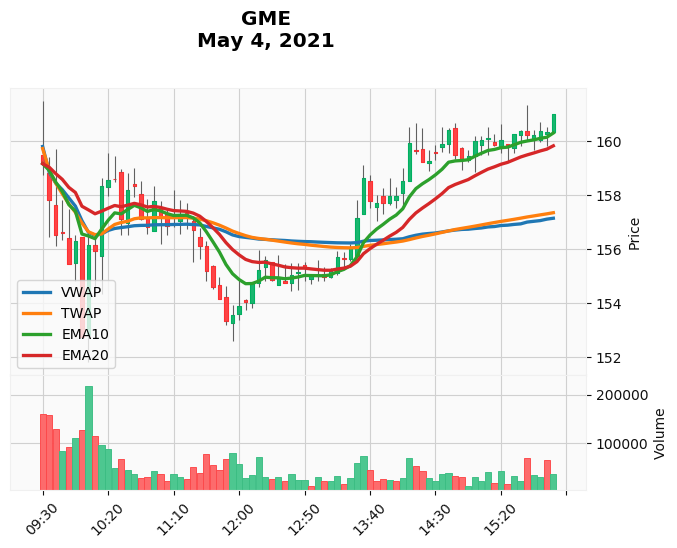

2021-05-04: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 11.424 GME short contracts at 159.1528 per contract
10:20:00: Close 11.424 GME short contracts at 158.532 per contract
10:20:00: Buy 11.514 GME shares at 158.532 per share
11:30:00: Sell 11.514 GME shares at 156.12 per share
11:30:00: Open 11.514 GME short contracts at 156.12 per contract
13:35:00: Close 11.514 GME short contracts at 158.6197 per contract
13:35:00: Buy 11.151 GME shares at 158.6197 per share
16:00:00: Sell 11.151 GME shares at 161.0 per share
Cash: 1795.2646103127774
Return: -1.26%
Transactions: 8
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 11.424 GME shares at 159.1528 per share
10:15:00: Sell 11.424 GME shares at 158.3087 per share
10:15:00: Open 11.424 GME short contracts at 158.3087 per contract
11:35:00: Close 11.424 GME short contracts at 155.16 per contract
11:35:00: Buy 11.888 GME shares at

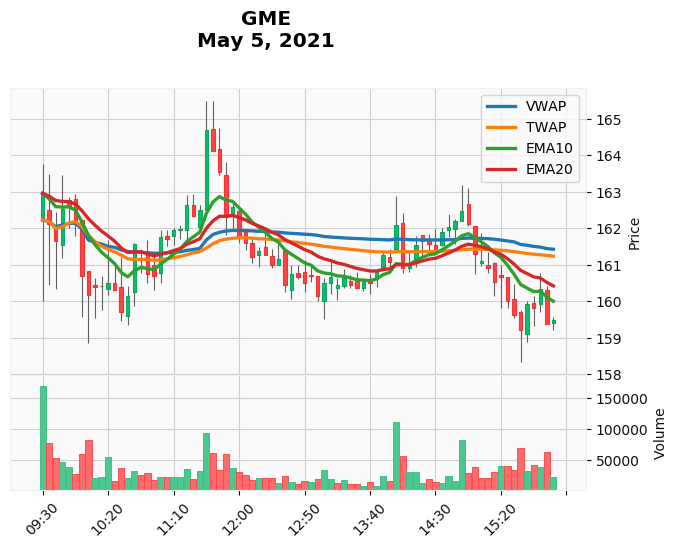

2021-05-05: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 11.157 GME shares at 162.96 per share
09:40:00: Sell 11.157 GME shares at 161.6392 per share
09:40:00: Open 11.157 GME short contracts at 161.6392 per contract
09:50:00: Close 11.157 GME short contracts at 162.61 per contract
09:50:00: Buy 11.024 GME shares at 162.61 per share
10:05:00: Sell 11.024 GME shares at 160.17 per share
10:05:00: Open 11.024 GME short contracts at 160.17 per contract
10:45:00: Close 11.024 GME short contracts at 161.37 per contract
10:45:00: Buy 10.860 GME shares at 161.37 per share
10:55:00: Sell 10.860 GME shares at 160.69 per share
10:55:00: Open 10.860 GME short contracts at 160.69 per contract
11:05:00: Close 10.860 GME short contracts at 161.71 per contract
11:05:00: Buy 10.723 GME shares at 161.71 per share
12:05:00: Sell 10.723 GME shares at 161.59 per share
12:05:00: Open 10.723 GME short contracts at 161.59 per contract
14:40:00: Close 10.723 GME short contracts at 162.03 per co

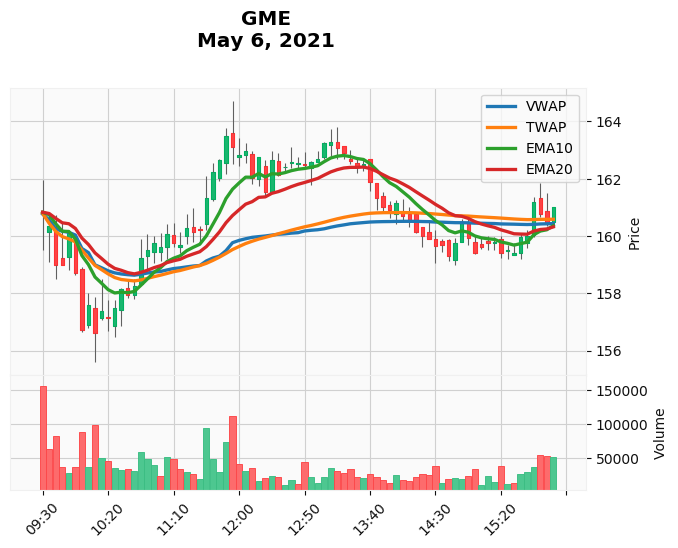

2021-05-06: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 11.305 GME shares at 160.827 per share
09:35:00: Sell 11.305 GME shares at 160.35 per share
09:35:00: Open 11.305 GME short contracts at 160.35 per contract
10:50:00: Close 11.305 GME short contracts at 159.5 per contract
10:50:00: Buy 11.426 GME shares at 159.5 per share
14:20:00: Sell 11.426 GME shares at 160.0 per share
14:20:00: Open 11.426 GME short contracts at 160.0 per contract
15:50:00: Close 11.426 GME short contracts at 160.76 per contract
15:50:00: Buy 11.318 GME shares at 160.76 per share
16:00:00: Sell 11.318 GME shares at 161.01 per share
Cash: 1822.2573940381594
Return: 0.22%
Transactions: 10
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 11.305 GME short contracts at 160.827 per contract
10:00:00: Close 11.305 GME short contracts at 156.7192 per contract
10:00:00: Buy 11.898 GME shares at 156.7192 per

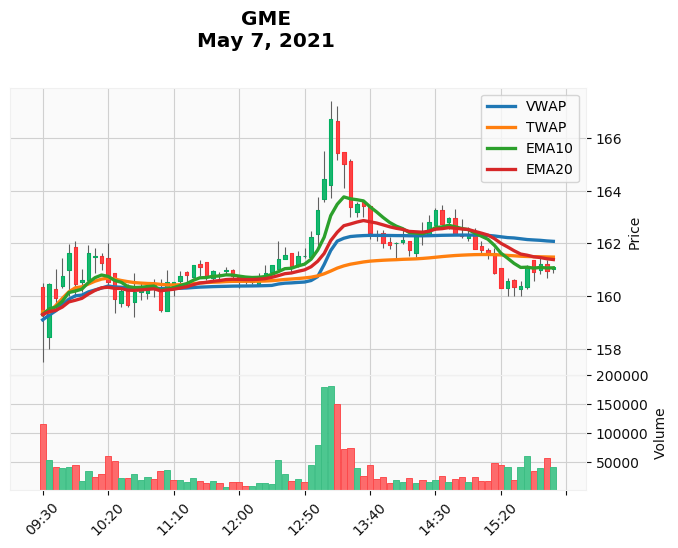

2021-05-07: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 11.414 GME shares at 159.3 per share
10:30:00: Sell 11.414 GME shares at 160.21 per share
10:30:00: Open 11.414 GME short contracts at 160.21 per contract
11:10:00: Close 11.414 GME short contracts at 160.52 per contract
11:10:00: Buy 11.369 GME shares at 160.52 per share
13:55:00: Sell 11.369 GME shares at 161.94 per share
13:55:00: Open 11.369 GME short contracts at 161.94 per contract
14:25:00: Close 11.369 GME short contracts at 162.825 per contract
14:25:00: Buy 11.246 GME shares at 162.825 per share
15:05:00: Sell 11.246 GME shares at 161.7414 per share
15:05:00: Open 11.246 GME short contracts at 161.7414 per contract
16:00:00: Close 11.246 GME short contracts at 161.1 per contract
Cash: 1826.139701681225
Return: 0.44%
Transactions: 12
----------------------------------------------------------------------
2021-05-07: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 11.414 GME short contracts at

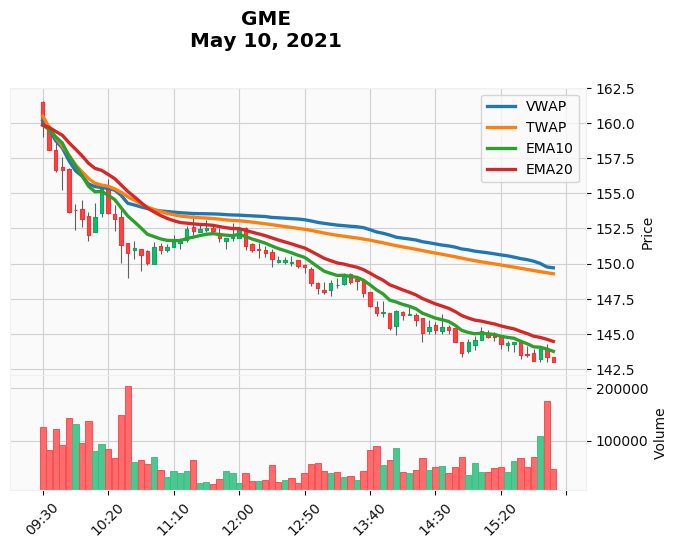

2021-05-10: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 11.374 GME short contracts at 159.85 per contract
16:00:00: Close 11.374 GME short contracts at 143.01 per contract
Cash: 2009.7250263030683
Return: 10.53%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 11.374 GME shares at 159.85 per share
16:00:00: Sell 11.374 GME shares at 143.01 per share
Cash: 1626.6386100605682
Return: -10.53%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $1818.18 USD
16:00:00: Sell 0.000 GME shares at 143.01 per share
Cash: 1818.1818181818182
Return: 0.00%
Transactions: 1
----------------------------------------------------------------------
2021-05-10: Starting VWAP + TWAP strategy with $1818.18 USD
09:30:00: Open 11.374 GME short contracts at 159.85 per contract
16:00:00: Close 11.374 GME sho

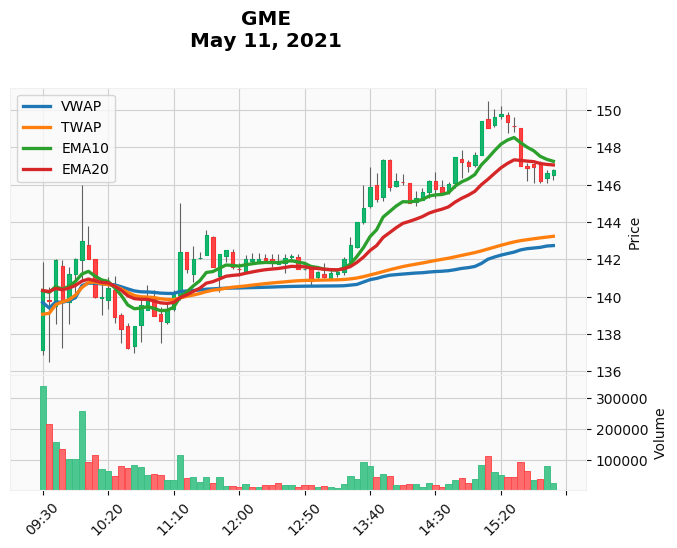

2021-05-11: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 12.956 GME shares at 140.33 per share
10:15:00: Sell 12.956 GME shares at 139.981 per share
10:15:00: Open 12.956 GME short contracts at 139.981 per contract
11:20:00: Close 12.956 GME short contracts at 141.473 per contract
11:20:00: Buy 12.683 GME shares at 141.473 per share
16:00:00: Sell 12.683 GME shares at 146.78 per share
Cash: 1861.6386417044057
Return: 2.39%
Transactions: 6
----------------------------------------------------------------------
2021-05-11: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 12.956 GME short contracts at 140.33 per contract
10:25:00: Close 12.956 GME short contracts at 138.9358 per contract
10:25:00: Buy 13.217 GME shares at 138.9358 per share
11:15:00: Sell 13.217 GME shares at 142.42 per share
11:15:00: Open 13.217 GME short contracts at 142.42 per contract
16:00:00: Close 13.217 GME short contracts at 146.78 per contract
Cash: 1824.6707171490382
Return: 0.36%
T

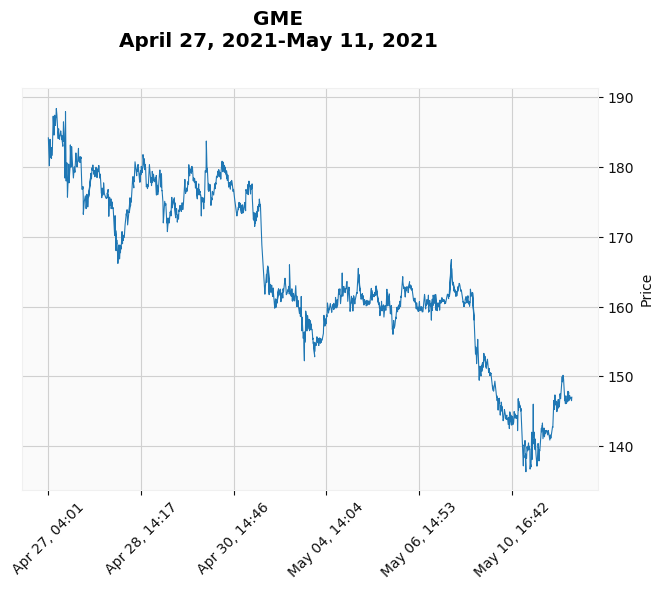

GME Returns
Strategy 1: 0.969%
Strategy 2: 1.193%
Strategy 3: -0.657%
Strategy 4: 0.760%
Market    : -1.274%
----------------------------------------------------------------------


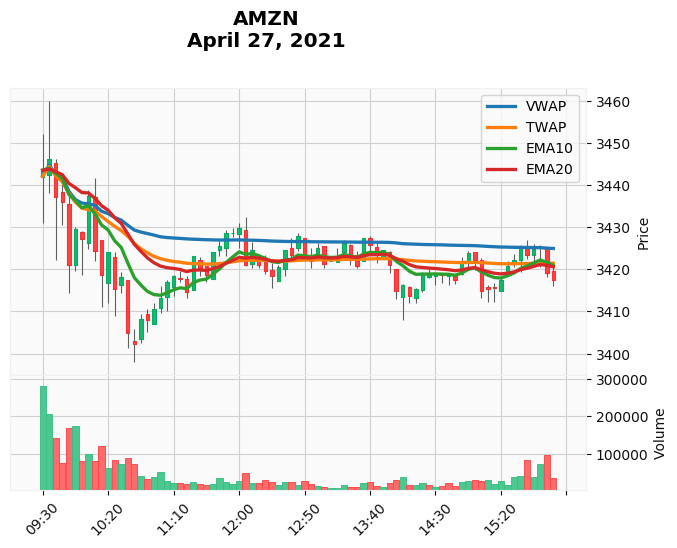

2021-04-27: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 0.528 AMZN shares at 3443.51 per share
09:45:00: Sell 0.528 AMZN shares at 3435.91 per share
09:45:00: Open 0.528 AMZN short contracts at 3435.91 per contract
11:55:00: Close 0.528 AMZN short contracts at 3428.645 per contract
11:55:00: Buy 0.530 AMZN shares at 3428.645 per share
12:10:00: Sell 0.530 AMZN shares at 3424.5327 per share
12:10:00: Open 0.530 AMZN short contracts at 3424.5327 per contract
16:00:00: Close 0.530 AMZN short contracts at 3417.43 per contract
Cash: 1819.5905672325691
Return: 0.08%
Transactions: 8
----------------------------------------------------------------------
2021-04-27: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 0.528 AMZN short contracts at 3443.51 per contract
16:00:00: Close 0.528 AMZN short contracts at 3417.43 per contract
Cash: 1831.952122847169
Return: 0.76%
Transactions: 2
----------------------------------------------------------------------
2021-04-27: 

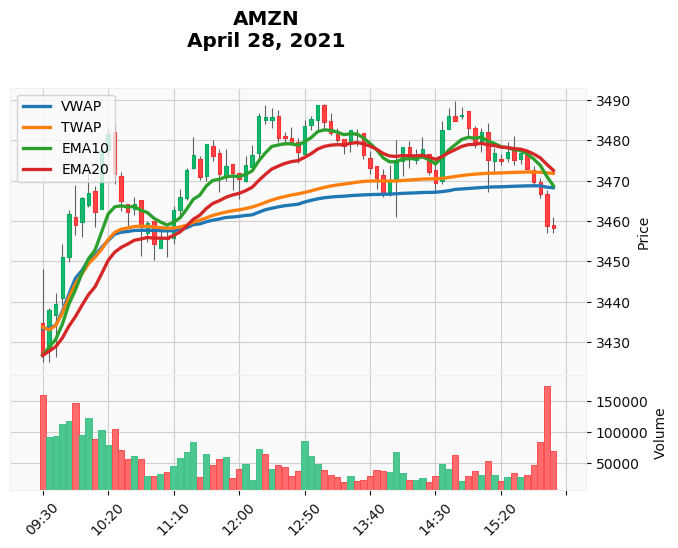

2021-04-28: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.531 AMZN short contracts at 3426.6201 per contract
09:40:00: Close 0.531 AMZN short contracts at 3439.395 per contract
09:40:00: Buy 0.527 AMZN shares at 3439.395 per share
11:00:00: Sell 0.527 AMZN shares at 3455.66 per share
11:00:00: Open 0.527 AMZN short contracts at 3455.66 per contract
11:15:00: Close 0.527 AMZN short contracts at 3466.0 per contract
11:15:00: Buy 0.524 AMZN shares at 3466.0 per share
15:55:00: Sell 0.524 AMZN shares at 3458.77 per share
15:55:00: Open 0.524 AMZN short contracts at 3458.77 per contract
16:00:00: Close 0.524 AMZN short contracts at 3458.28 per contract
Cash: 1810.9953409551297
Return: -0.40%
Transactions: 10
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 0.531 AMZN shares at 3426.6201 per share
16:00:00: Sell 0.531 AMZN shares at 3458.28 per share
Cash: 1834.980719975879
Return

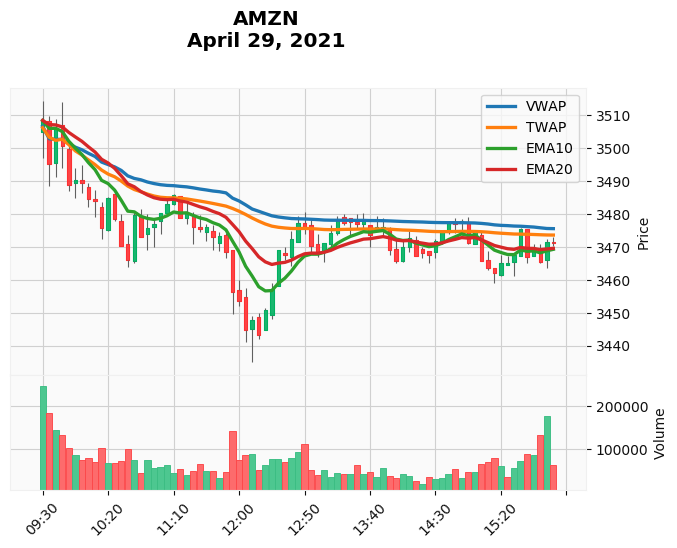

2021-04-29: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 0.518 AMZN shares at 3508.44 per share
09:50:00: Sell 0.518 AMZN shares at 3488.8775 per share
09:50:00: Open 0.518 AMZN short contracts at 3488.8775 per contract
14:50:00: Close 0.518 AMZN short contracts at 3477.9499 per contract
14:50:00: Buy 0.521 AMZN shares at 3477.9499 per share
15:00:00: Sell 0.521 AMZN shares at 3474.5404 per share
15:00:00: Open 0.521 AMZN short contracts at 3474.5404 per contract
16:00:00: Close 0.521 AMZN short contracts at 3471.31 per contract
Cash: 1813.6135482891711
Return: -0.25%
Transactions: 8
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 0.518 AMZN short contracts at 3508.44 per contract
12:05:00: Close 0.518 AMZN short contracts at 3444.62 per contract
12:05:00: Buy 0.537 AMZN shares at 3444.62 per share
16:00:00: Sell 0.537 AMZN shares at 3471.31 per share
Cash: 1865.599419424116

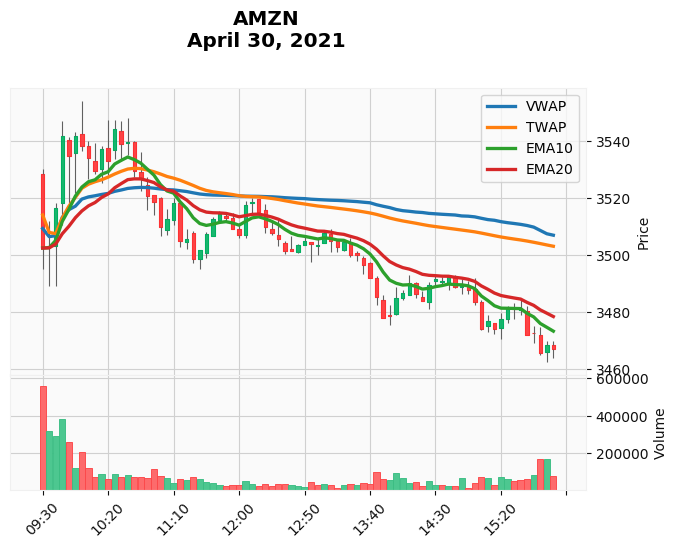

2021-04-30: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.519 AMZN short contracts at 3502.39 per contract
09:45:00: Close 0.519 AMZN short contracts at 3541.69 per contract
09:45:00: Buy 0.508 AMZN shares at 3541.69 per share
10:55:00: Sell 0.508 AMZN shares at 3518.61 per share
10:55:00: Open 0.508 AMZN short contracts at 3518.61 per contract
16:00:00: Close 0.508 AMZN short contracts at 3467.2 per contract
Cash: 1812.1606197319488
Return: -0.33%
Transactions: 6
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 0.519 AMZN shares at 3502.39 per share
16:00:00: Sell 0.519 AMZN shares at 3467.2 per share
Cash: 1799.9137731663236
Return: -1.00%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 0.519 AMZN shares at 3503.29 per share
11:05:00: Sell 0.519 AMZN shares at 351

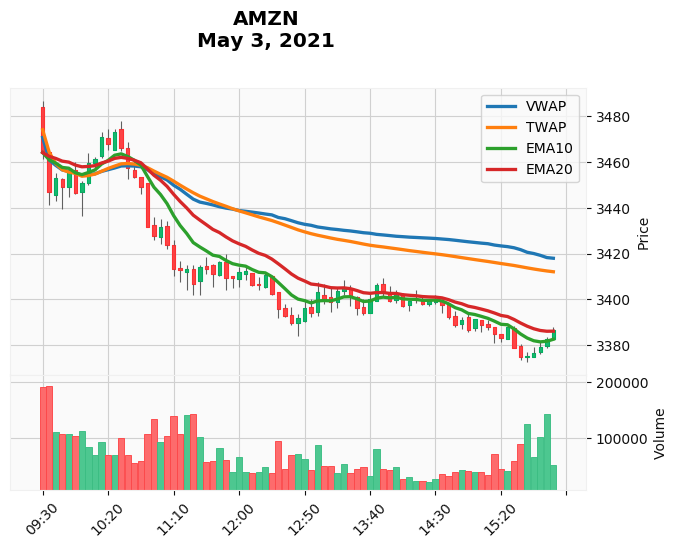

2021-05-03: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.525 AMZN short contracts at 3464.01 per contract
10:10:00: Close 0.525 AMZN short contracts at 3461.42 per contract
10:10:00: Buy 0.526 AMZN shares at 3461.42 per share
10:40:00: Sell 0.526 AMZN shares at 3453.2039 per share
10:40:00: Open 0.526 AMZN short contracts at 3453.2039 per contract
16:00:00: Close 0.526 AMZN short contracts at 3386.49 per contract
Cash: 1850.291394657266
Return: 1.77%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 0.525 AMZN shares at 3464.01 per share
16:00:00: Sell 0.525 AMZN shares at 3386.49 per share
Cash: 1777.4932940304864
Return: -2.24%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $1818.18 USD
10:20:00: Buy 0.524 AMZN shares at 3467.8 per share
10:40:00: Sell 0.524 AMZN shares at 

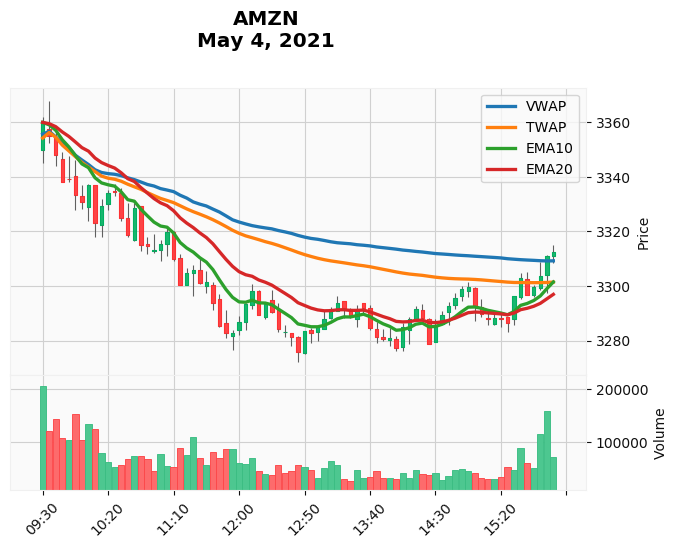

2021-05-04: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 0.541 AMZN shares at 3360.0 per share
09:40:00: Sell 0.541 AMZN shares at 3348.0 per share
09:40:00: Open 0.541 AMZN short contracts at 3348.0 per contract
16:00:00: Close 0.541 AMZN short contracts at 3312.65 per contract
16:00:00: Buy 0.553 AMZN shares at 3312.65 per share
16:00:00: Sell 0.553 AMZN shares at 3312.65 per share
Cash: 1830.8170995670996
Return: 0.69%
Transactions: 6
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 0.541 AMZN short contracts at 3360.0 per contract
11:40:00: Close 0.541 AMZN short contracts at 3293.7056 per contract
11:40:00: Buy 0.563 AMZN shares at 3293.7056 per share
16:00:00: Sell 0.563 AMZN shares at 3312.65 per share
Cash: 1864.7193781056935
Return: 2.56%
Transactions: 4
----------------------------------------------------------------------
2021-05-04: Starting EMA Cross strategy wit

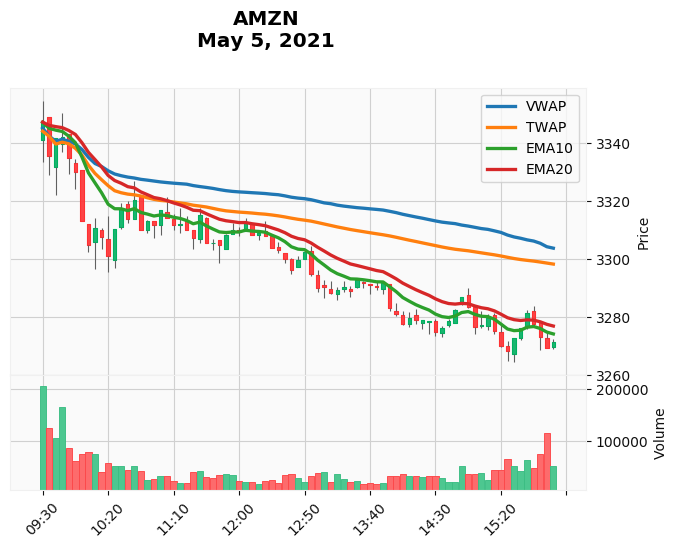

2021-05-05: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 0.543 AMZN shares at 3347.27 per share
09:55:00: Sell 0.543 AMZN shares at 3330.0828 per share
09:55:00: Open 0.543 AMZN short contracts at 3330.0828 per contract
16:00:00: Close 0.543 AMZN short contracts at 3271.17 per contract
Cash: 1840.846475431675
Return: 1.25%
Transactions: 4
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 0.543 AMZN short contracts at 3347.27 per contract
13:55:00: Close 0.543 AMZN short contracts at 3283.0 per contract
13:55:00: Buy 0.564 AMZN shares at 3283.0 per share
16:00:00: Sell 0.564 AMZN shares at 3271.17 per share
Cash: 1846.414767575318
Return: 1.55%
Transactions: 4
----------------------------------------------------------------------
2021-05-05: Starting EMA Cross strategy with $1818.18 USD
16:00:00: Sell 0.000 AMZN shares at 3271.17 per share
Cash: 1818.1818181818182
Return: 0.00%

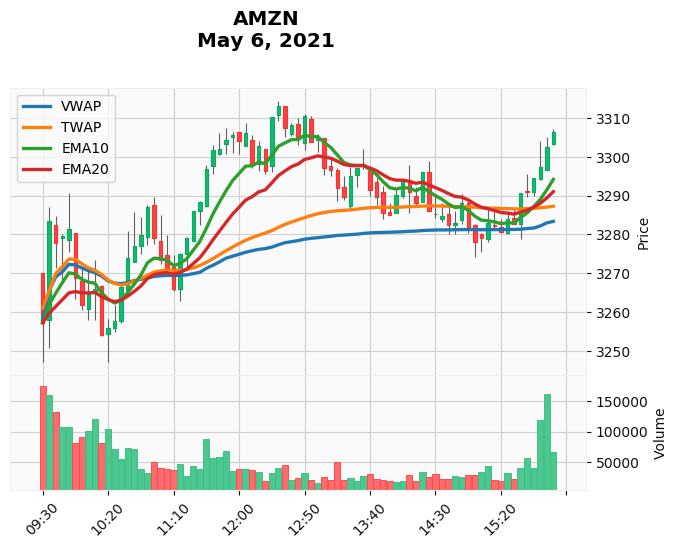

2021-05-06: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.558 AMZN short contracts at 3257.27 per contract
09:40:00: Close 0.558 AMZN short contracts at 3277.84 per contract
09:40:00: Buy 0.551 AMZN shares at 3277.84 per share
10:00:00: Sell 0.551 AMZN shares at 3261.845 per share
10:00:00: Open 0.551 AMZN short contracts at 3261.845 per contract
10:40:00: Close 0.551 AMZN short contracts at 3277.005 per contract
10:40:00: Buy 0.546 AMZN shares at 3277.005 per share
15:05:00: Sell 0.546 AMZN shares at 3279.0 per share
15:05:00: Open 0.546 AMZN short contracts at 3279.0 per contract
15:15:00: Close 0.546 AMZN short contracts at 3282.06 per contract
15:15:00: Buy 0.545 AMZN shares at 3282.06 per share
16:00:00: Sell 0.545 AMZN shares at 3306.37 per share
Cash: 1802.1966298629416
Return: -0.88%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 0.558 AMZN shares 

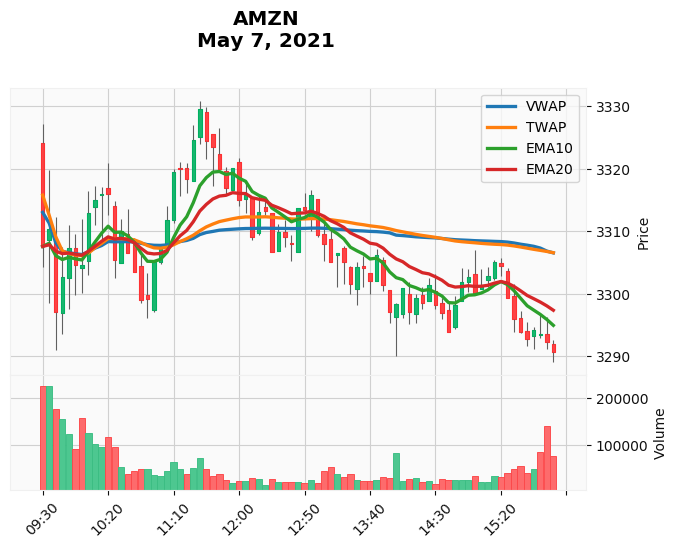

2021-05-07: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.550 AMZN short contracts at 3307.56 per contract
10:10:00: Close 0.550 AMZN short contracts at 3315.0 per contract
10:10:00: Buy 0.547 AMZN shares at 3315.0 per share
10:40:00: Sell 0.547 AMZN shares at 3303.46 per share
10:40:00: Open 0.547 AMZN short contracts at 3303.46 per contract
11:05:00: Close 0.547 AMZN short contracts at 3311.735 per contract
11:05:00: Buy 0.545 AMZN shares at 3311.735 per share
12:30:00: Sell 0.545 AMZN shares at 3309.9109 per share
12:30:00: Open 0.545 AMZN short contracts at 3309.9109 per contract
12:50:00: Close 0.545 AMZN short contracts at 3313.45 per contract
12:50:00: Buy 0.543 AMZN shares at 3313.45 per share
13:05:00: Sell 0.543 AMZN shares at 3308.015 per share
13:05:00: Open 0.543 AMZN short contracts at 3308.015 per contract
16:00:00: Close 0.543 AMZN short contracts at 3290.69 per contract
Cash: 1806.788534590674
Return: -0.63%
Transactions: 14
--------------------------

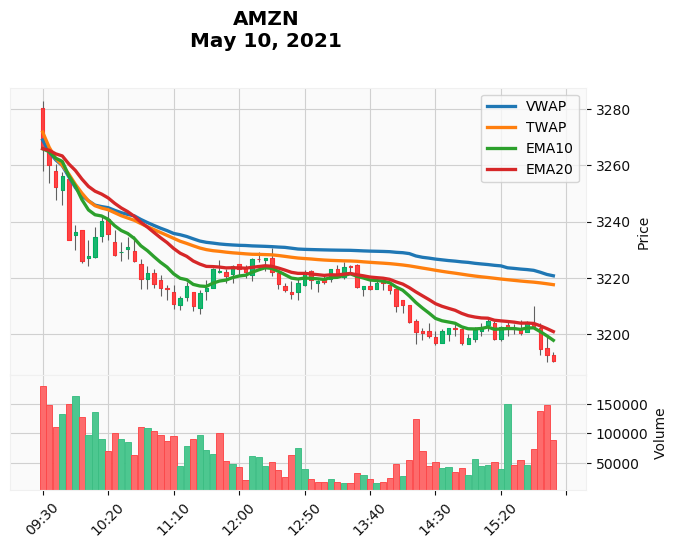

2021-05-10: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 0.557 AMZN short contracts at 3265.9 per contract
16:00:00: Close 0.557 AMZN short contracts at 3190.49 per contract
Cash: 1860.1638417921833
Return: 2.31%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 0.557 AMZN shares at 3265.9 per share
16:00:00: Sell 0.557 AMZN shares at 3190.49 per share
Cash: 1776.1997945714531
Return: -2.31%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $1818.18 USD
16:00:00: Sell 0.000 AMZN shares at 3190.49 per share
Cash: 1818.1818181818182
Return: 0.00%
Transactions: 1
----------------------------------------------------------------------
2021-05-10: Starting VWAP + TWAP strategy with $1818.18 USD
09:30:00: Open 0.557 AMZN short contracts at 3265.9 per contract
16:00:00: Close 0.557 AMZN s

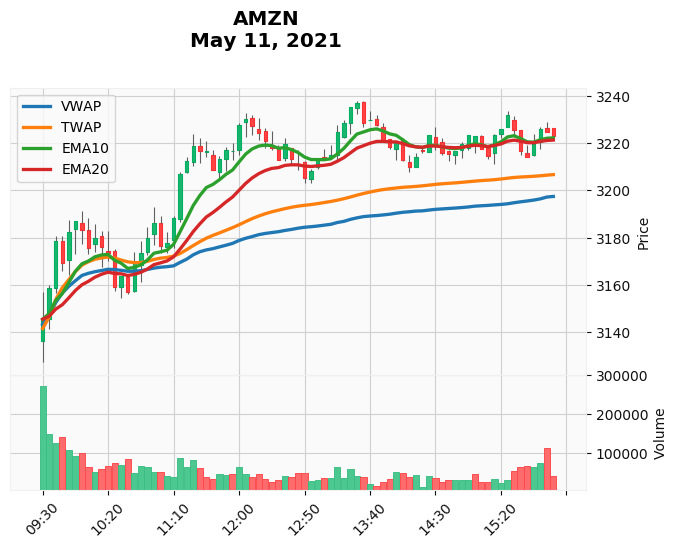

2021-05-11: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 0.578 AMZN shares at 3145.5 per share
10:30:00: Sell 0.578 AMZN shares at 3163.61 per share
10:30:00: Open 0.578 AMZN short contracts at 3163.61 per contract
10:45:00: Close 0.578 AMZN short contracts at 3173.401 per contract
10:45:00: Buy 0.574 AMZN shares at 3173.401 per share
16:00:00: Sell 0.574 AMZN shares at 3223.11 per share
Cash: 1851.5462275557145
Return: 1.84%
Transactions: 6
----------------------------------------------------------------------
2021-05-11: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 0.578 AMZN short contracts at 3145.5 per contract
16:00:00: Close 0.578 AMZN short contracts at 3223.11 per contract
Cash: 1773.321194780422
Return: -2.47%
Transactions: 2
----------------------------------------------------------------------
2021-05-11: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 0.576 AMZN shares at 3158.535 per share
14:15:00: Sell 0.576 AMZN shares at 32

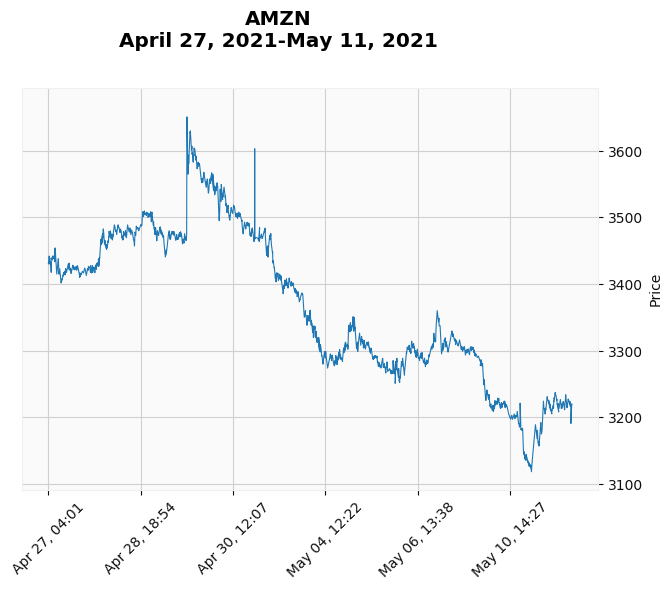

AMZN Returns
Strategy 1: 0.495%
Strategy 2: 0.147%
Strategy 3: -0.045%
Strategy 4: -0.366%
Market    : -0.780%
----------------------------------------------------------------------


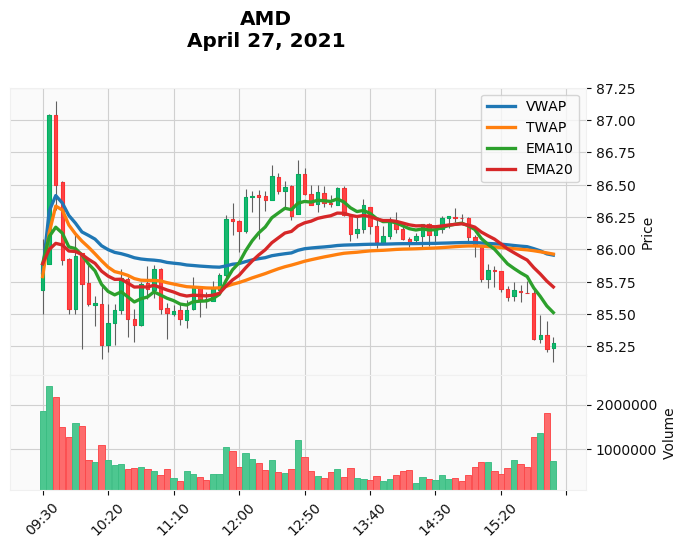

2021-04-27: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 21.169 AMD shares at 85.89 per share
09:50:00: Sell 21.169 AMD shares at 85.54 per share
09:50:00: Open 21.169 AMD short contracts at 85.54 per contract
11:55:00: Close 21.169 AMD short contracts at 86.22 per contract
11:55:00: Buy 20.835 AMD shares at 86.22 per share
15:05:00: Sell 20.835 AMD shares at 85.77 per share
15:05:00: Open 20.835 AMD short contracts at 85.77 per contract
16:00:00: Close 20.835 AMD short contracts at 85.28 per contract
Cash: 1797.211423827592
Return: -1.15%
Transactions: 8
----------------------------------------------------------------------
2021-04-27: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 21.169 AMD short contracts at 85.89 per contract
16:00:00: Close 21.169 AMD short contracts at 85.28 per contract
Cash: 1831.094740630193
Return: 0.71%
Transactions: 2
----------------------------------------------------------------------
2021-04-27: Starting EMA Cross strateg

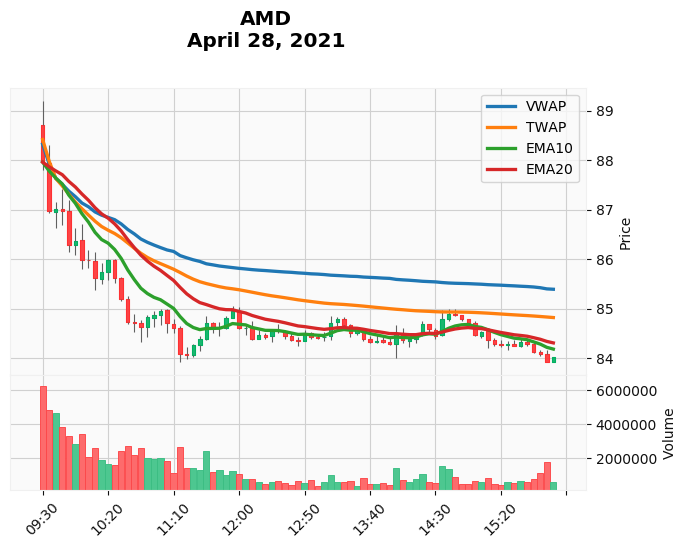

2021-04-28: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 20.671 AMD short contracts at 87.9577 per contract
16:00:00: Close 20.671 AMD short contracts at 84.02 per contract
Cash: 1899.5783820466597
Return: 4.48%
Transactions: 2
----------------------------------------------------------------------
2021-04-28: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 20.671 AMD shares at 87.9577 per share
16:00:00: Sell 20.671 AMD shares at 84.02 per share
Cash: 1736.7852543169768
Return: -4.48%
Transactions: 2
----------------------------------------------------------------------
2021-04-28: Starting EMA Cross strategy with $1818.18 USD
14:35:00: Buy 21.445 AMD shares at 84.785 per share
15:15:00: Sell 21.445 AMD shares at 84.275 per share
16:00:00: Sell 0.000 AMD shares at 84.02 per share
Cash: 1807.2450637173174
Return: -0.60%
Transactions: 3
----------------------------------------------------------------------
2021-04-28: Starting VWAP + TWAP strategy with $1818

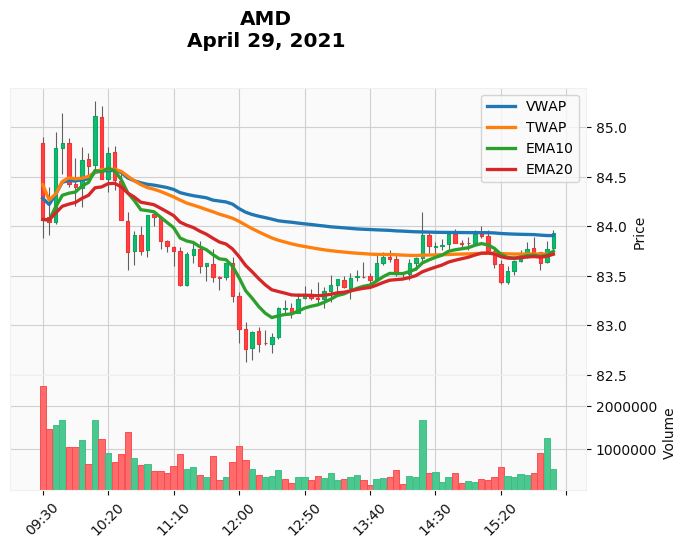

2021-04-29: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 21.627 AMD short contracts at 84.0701 per contract
09:45:00: Close 21.627 AMD short contracts at 84.8383 per contract
09:45:00: Buy 21.235 AMD shares at 84.8383 per share
09:55:00: Sell 21.235 AMD shares at 84.4 per share
09:55:00: Open 21.235 AMD short contracts at 84.4 per contract
10:05:00: Close 21.235 AMD short contracts at 84.6111 per contract
10:05:00: Buy 21.129 AMD shares at 84.6111 per share
10:30:00: Sell 21.129 AMD shares at 84.06 per share
10:30:00: Open 21.129 AMD short contracts at 84.06 per contract
16:00:00: Close 21.129 AMD short contracts at 83.93 per contract
Cash: 1778.8801936304953
Return: -2.16%
Transactions: 10
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 21.627 AMD shares at 84.0701 per share
16:00:00: Sell 21.627 AMD shares at 83.93 per share
Cash: 1815.1518792055679
Return: -0.17%
Transact

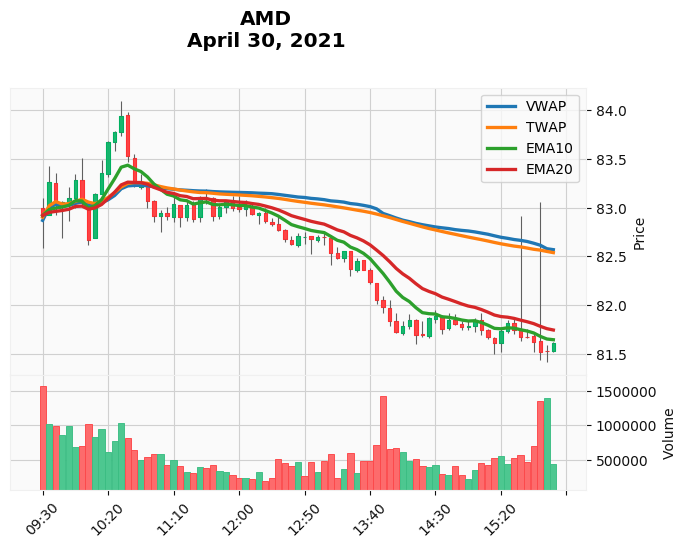

2021-04-30: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 21.927 AMD shares at 82.92 per share
10:55:00: Sell 21.927 AMD shares at 82.91 per share
10:55:00: Open 21.927 AMD short contracts at 82.91 per contract
16:00:00: Close 21.927 AMD short contracts at 81.61 per contract
Cash: 1846.4675700565715
Return: 1.56%
Transactions: 4
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 21.927 AMD short contracts at 82.92 per contract
13:45:00: Close 21.927 AMD short contracts at 82.055 per contract
13:45:00: Buy 22.389 AMD shares at 82.055 per share
16:00:00: Sell 22.389 AMD shares at 81.61 per share
Cash: 1827.1854115303333
Return: 0.50%
Transactions: 4
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 21.837 AMD shares at 83.26 per share
11:05:00: Sell 21.837 AMD shares at 82.91 per share
16:

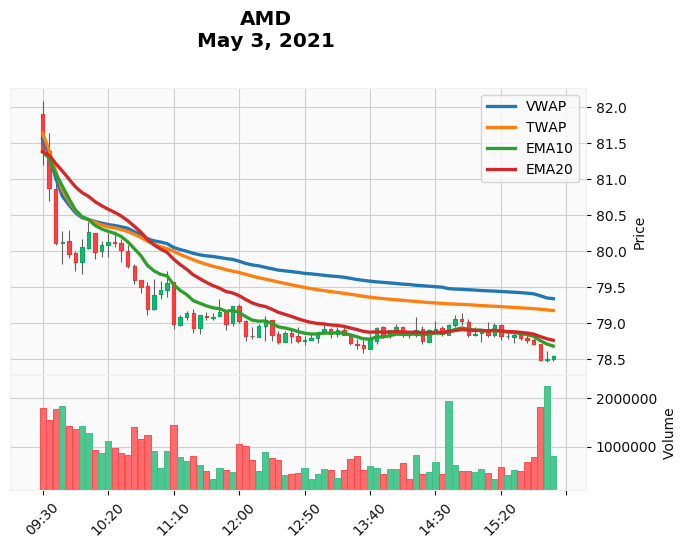

2021-05-03: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 22.342 AMD short contracts at 81.38 per contract
16:00:00: Close 22.342 AMD short contracts at 78.55 per contract
Cash: 1881.4093254987822
Return: 3.48%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 22.342 AMD shares at 81.38 per share
16:00:00: Sell 22.342 AMD shares at 78.55 per share
Cash: 1754.9543108648543
Return: -3.48%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $1818.18 USD
14:45:00: Buy 22.999 AMD shares at 79.055 per share
15:10:00: Sell 22.999 AMD shares at 78.835 per share
15:15:00: Buy 22.960 AMD shares at 78.97 per share
15:20:00: Sell 22.960 AMD shares at 78.815 per share
16:00:00: Sell 0.000 AMD shares at 78.55 per share
Cash: 1809.5633068816476
Return: -0.47%
Transactions: 5
-----------------------

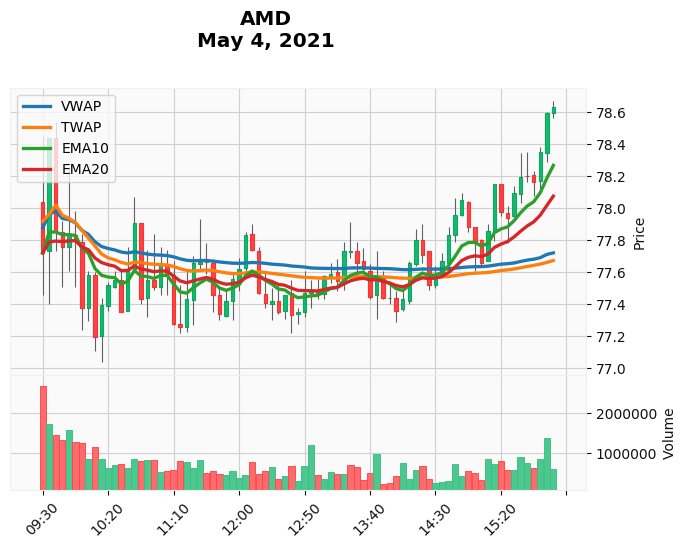

2021-05-04: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 23.394 AMD short contracts at 77.72 per contract
12:10:00: Close 23.394 AMD short contracts at 77.74 per contract
12:10:00: Buy 23.382 AMD shares at 77.74 per share
12:20:00: Sell 23.382 AMD shares at 77.405 per share
12:20:00: Open 23.382 AMD short contracts at 77.405 per contract
13:25:00: Close 23.382 AMD short contracts at 77.73 per contract
13:25:00: Buy 23.186 AMD shares at 77.73 per share
13:40:00: Sell 23.186 AMD shares at 77.448 per share
13:40:00: Open 23.186 AMD short contracts at 77.448 per contract
14:15:00: Close 23.186 AMD short contracts at 77.8 per contract
14:15:00: Buy 22.977 AMD shares at 77.8 per share
14:30:00: Sell 22.977 AMD shares at 77.59 per share
14:30:00: Open 22.977 AMD short contracts at 77.59 per contract
14:40:00: Close 22.977 AMD short contracts at 77.835 per contract
14:40:00: Buy 22.832 AMD shares at 77.835 per share
16:00:00: Sell 22.832 AMD shares at 78.6294 per share
Cash: 1

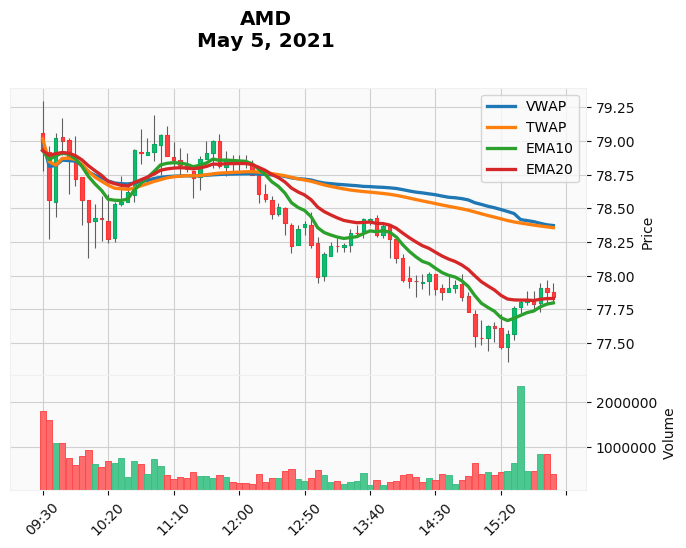

2021-05-05: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 23.035 AMD short contracts at 78.93 per contract
09:45:00: Close 23.035 AMD short contracts at 78.9977 per contract
09:45:00: Buy 22.996 AMD shares at 78.9977 per share
10:00:00: Sell 22.996 AMD shares at 78.56 per share
10:00:00: Open 22.996 AMD short contracts at 78.56 per contract
10:45:00: Close 22.996 AMD short contracts at 78.91 per contract
10:45:00: Buy 22.792 AMD shares at 78.91 per share
12:15:00: Sell 22.792 AMD shares at 78.61 per share
12:15:00: Open 22.792 AMD short contracts at 78.61 per contract
16:00:00: Close 22.792 AMD short contracts at 77.84 per contract
Cash: 1809.2206527948208
Return: -0.49%
Transactions: 10
----------------------------------------------------------------------
2021-05-05: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 23.035 AMD shares at 78.93 per share
16:00:00: Sell 23.035 AMD shares at 77.84 per share
Cash: 1793.0732639968671
Return: -1.38%
Transactions: 

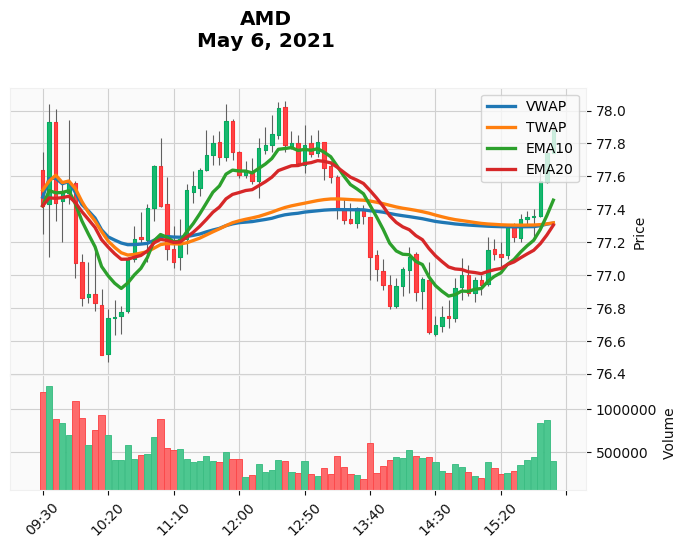

2021-05-06: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 23.485 AMD short contracts at 77.4199 per contract
10:45:00: Close 23.485 AMD short contracts at 77.22 per contract
10:45:00: Buy 23.606 AMD shares at 77.22 per share
11:10:00: Sell 23.606 AMD shares at 77.08 per share
11:10:00: Open 23.606 AMD short contracts at 77.08 per contract
11:25:00: Close 23.606 AMD short contracts at 77.5387 per contract
11:25:00: Buy 23.327 AMD shares at 77.5387 per share
13:25:00: Sell 23.327 AMD shares at 77.315 per share
13:25:00: Open 23.327 AMD short contracts at 77.315 per contract
15:40:00: Close 23.327 AMD short contracts at 77.35 per contract
15:40:00: Buy 23.306 AMD shares at 77.35 per share
16:00:00: Sell 23.306 AMD shares at 77.88 per share
Cash: 1815.060750513519
Return: -0.17%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 23.485 AMD shares at 77.4199 per shar

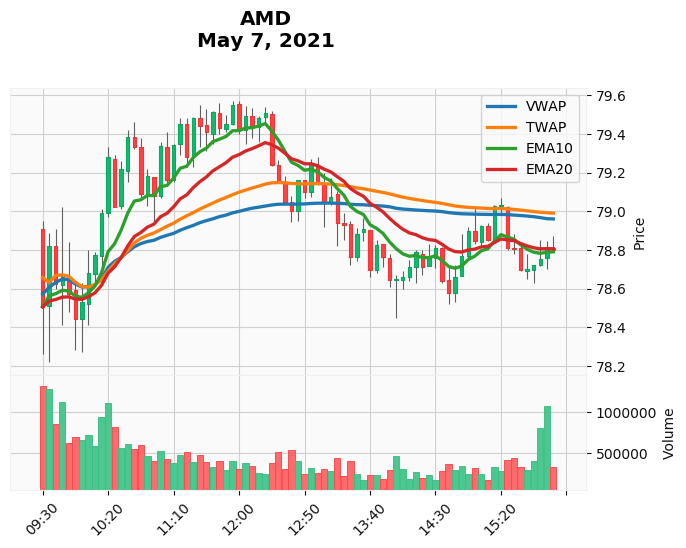

2021-05-07: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 23.160 AMD short contracts at 78.505 per contract
10:10:00: Close 23.160 AMD short contracts at 78.775 per contract
10:10:00: Buy 23.001 AMD shares at 78.775 per share
13:20:00: Sell 23.001 AMD shares at 78.93 per share
13:20:00: Open 23.001 AMD short contracts at 78.93 per contract
15:20:00: Close 23.001 AMD short contracts at 79.03 per contract
15:20:00: Buy 22.943 AMD shares at 79.03 per share
15:30:00: Sell 22.943 AMD shares at 78.805 per share
15:30:00: Open 22.943 AMD short contracts at 78.805 per contract
16:00:00: Close 22.943 AMD short contracts at 78.8 per contract
Cash: 1808.1461864871599
Return: -0.55%
Transactions: 10
----------------------------------------------------------------------
2021-05-07: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 23.160 AMD shares at 78.505 per share
16:00:00: Sell 23.160 AMD shares at 78.8 per share
Cash: 1825.0140407964752
Return: 0.38%
Transactions: 2

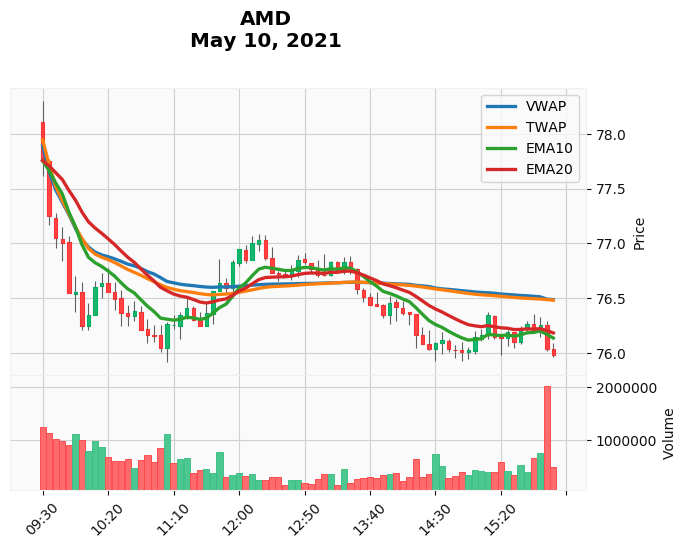

2021-05-10: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Open 23.384 AMD short contracts at 77.7537 per contract
12:00:00: Close 23.384 AMD short contracts at 76.945 per contract
12:00:00: Buy 23.875 AMD shares at 76.945 per share
13:35:00: Sell 23.875 AMD shares at 76.51 per share
13:35:00: Open 23.875 AMD short contracts at 76.51 per contract
16:00:00: Close 23.875 AMD short contracts at 75.98 per contract
Cash: 1839.3605102891415
Return: 1.16%
Transactions: 6
----------------------------------------------------------------------
2021-05-10: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Buy 23.384 AMD shares at 77.7537 per share
16:00:00: Sell 23.384 AMD shares at 75.98 per share
Cash: 1776.7058615275487
Return: -2.28%
Transactions: 2
----------------------------------------------------------------------
2021-05-10: Starting EMA Cross strategy with $1818.18 USD
12:00:00: Buy 23.630 AMD shares at 76.945 per share
13:35:00: Sell 23.630 AMD shares at 76.51 per sha

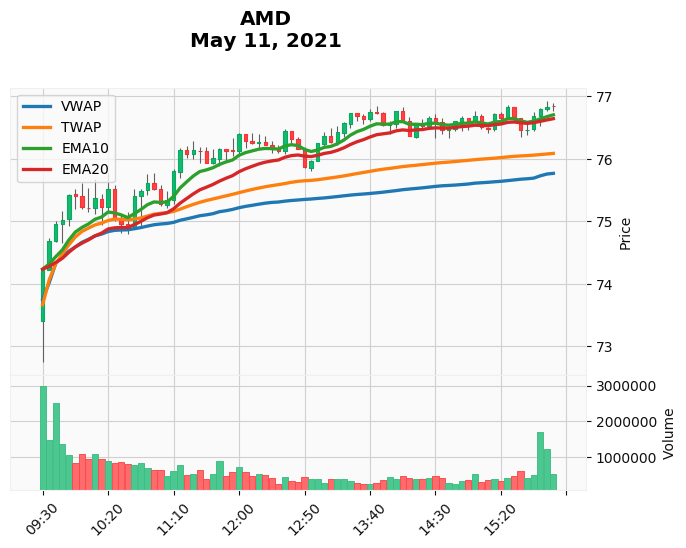

2021-05-11: Starting VWAP Cross strategy with $1818.18 USD
09:30:00: Buy 24.492 AMD shares at 74.235 per share
16:00:00: Sell 24.492 AMD shares at 76.84 per share
Cash: 1881.984116779025
Return: 3.51%
Transactions: 2
----------------------------------------------------------------------
2021-05-11: Starting VWAP Mean reversion with $1818.18 USD
09:30:00: Open 24.492 AMD short contracts at 74.235 per contract
16:00:00: Close 24.492 AMD short contracts at 76.84 per contract
Cash: 1754.3795195846114
Return: -3.51%
Transactions: 2
----------------------------------------------------------------------
2021-05-11: Starting EMA Cross strategy with $1818.18 USD
09:35:00: Buy 24.343 AMD shares at 74.69 per share
16:00:00: Sell 24.343 AMD shares at 76.84 per share
Cash: 1870.51935880427
Return: 2.88%
Transactions: 2
----------------------------------------------------------------------
2021-05-11: Starting VWAP + TWAP strategy with $1818.18 USD
09:30:00: Buy 24.492 AMD shares at 74.235 per share

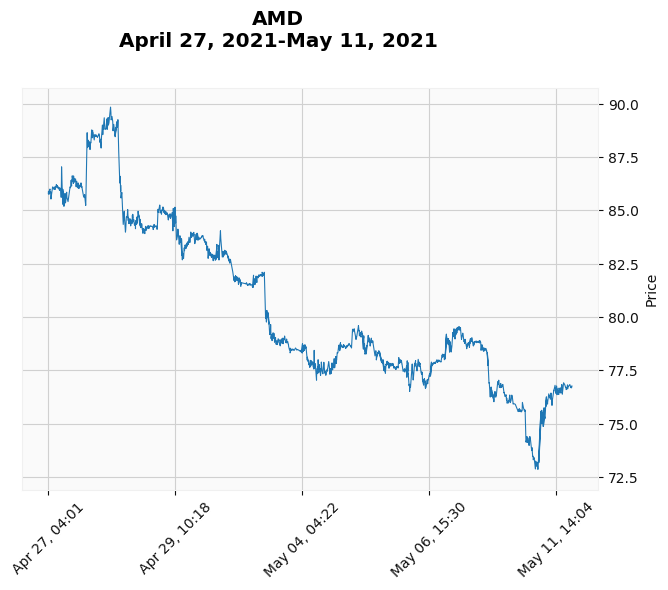

AMD Returns
Strategy 1: 0.763%
Strategy 2: -1.095%
Strategy 3: -0.357%
Strategy 4: 1.308%
Market    : -1.023%
----------------------------------------------------------------------
Portfolio Returns
Strategy 1: 0.559%
Strategy 2: -0.074%
Strategy 3: -0.275%
Strategy 4: 0.445%
Market    : -0.862%
----------------------------------------------------------------------


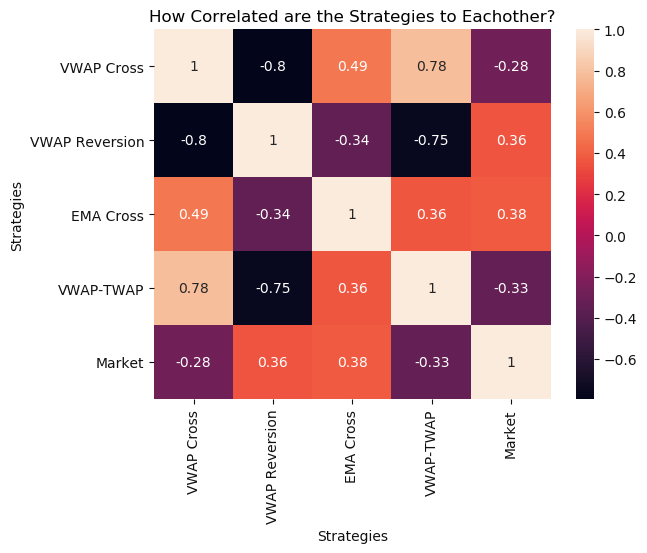

In [12]:
portfolio = ['AAPL','TSLA','GME','AMZN','AMD'] 
cash = 100000 
show_transactions = True 
show_graphs       = True 
main(portfolio,cash,show_transactions,show_graphs) 